In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from datetime import timedelta
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
# plotting parameters
figure_size = (6.25984252, 4.313975656) # = 15.9, 10.957 cm  (10.95749816624)

def rgb(rgb_255_tuple):
    return tuple(v/255 for v in rgb_255_tuple)

colour_op = rgb((13, 103, 53))
colour_s = rgb((254, 205, 8))
colour_p = rgb((237, 29, 36))

sns.set_palette('muted')

# Raw data processing

# Inflow profile calculation

In [3]:
df = pd.read_csv('K3 data 1 min_2017-09-19.pdi.gz')

# also make forward filled
time_interval = pd.Timedelta(minutes=1)
df = df.pivot_table(values='Value', columns='TagName', index=(pd.to_datetime(df['Date'].str.cat(df['Time'], sep=' ')) - time_interval))
df.index.name = 'DateTime'

df['Time_30'] = df.index.floor('30min').time

df['EskomDayOfWeek'] = df.index.dayofweek + 1
# replace holidays with Eskom days
h_path = '..\\holidays.csv'
holidays = np.genfromtxt(h_path,  dtype=np.dtype('M'), delimiter=',', usecols=0)
holidays = list(holidays)
holidays_numbers = np.genfromtxt(h_path, dtype=int, delimiter=',', usecols=1)
holidays_numbers = list(holidays_numbers)
for h_n, h_d in zip(holidays_numbers, holidays):
    df.loc[df.index.date==h_d,'EskomDayOfWeek'] = h_n
# drop weekends
df = df[df['EskomDayOfWeek'] <= 5]
df.drop('EskomDayOfWeek', axis=1)

df.head()

TagName              KDCE_S01_31INS01_00IFT#505.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                        190.613326   
2017-01-03 00:01:00                        191.185310   
2017-01-03 00:02:00                        191.852380   
2017-01-03 00:03:00                        192.684271   
2017-01-03 00:04:00                        193.303978   

TagName              KDCE_S03_30INS00_00IFT#501.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                        276.329897   
2017-01-03 00:01:00                        276.667415   
2017-01-03 00:02:00                        277.123861   
2017-01-03 00:03:00                        276.717341   
2017-01-03 00:04:00                        277.537946   

TagName              KDCE_S03_30INS00_00ILT#501.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                         40.915051   
2017-01-03 00:01:00                         40.869027   
2017-01-03 00:02:00                         40.811069   
2017-01-03 00:03:00                         40.735534   
2017-01-03 00:04:00                         40.648078   

TagName              KDCE_S03_30INS00_00ILT#502.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                          7.613364   
2017-01-03 00:01:00                          7.525664   
2017-01-03 00:02:00                          7.457779   
2017-01-03 00:03:00                          7.387303   
2017-01-03 00:04:00                          7.292373   

TagName              KDCE_S03_43INS00_00ILT#503.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                         79.410149   
2017-01-03 00:01:00                         79.218411   
2017-01-03 00:02:00                         78.861461   
2017-01-03 00:03:00                         78.712480   
2017-01-03 00:04:00                         78.354963   

TagName              KDCE_S03_43INS00_00ILT#504.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                          5.080543   
2017-01-03 00:01:00                          5.095167   
2017-01-03 00:02:00                          5.095167   
2017-01-03 00:03:00                          5.082732   
2017-01-03 00:04:00                          5.026379   

TagName              KDCE_S03_43INS00_01ILT#503.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                               NaN   
2017-01-03 00:01:00                               NaN   
2017-01-03 00:02:00                               NaN   
2017-01-03 00:03:00                               NaN   
2017-01-03 00:04:00                               NaN   

TagName              KDCE_S03_43INS00_01ILT#504.FA_PV  \
DateTime                                                
2017-01-03 00:00:00                               NaN   
2017-01-03 00:01:00                               NaN   
2017-01-03 00:02:00                               NaN   
2017-01-03 00:03:00                               NaN   
2017-01-03 00:04:00                               NaN   

TagName              KDCE_S03_44PMP01_Machine.FA_RF  \
DateTime                                              
2017-01-03 00:00:00                             1.0   
2017-01-03 00:01:00                             NaN   
2017-01-03 00:02:00                             1.0   
2017-01-03 00:03:00                             1.0   
2017-01-03 00:04:00                             1.0   

TagName              KDCE_S03_44PMP02_Machine.FA_RF  \
DateTime                                              
2017-01-03 00:00:00                             1.0   
2017-01-03 00:01:00                             NaN   
2017-01-03 00:02:00                             1.0   
2017-01-03 00:03:00                             1.0   
2017-01-03 00:04:00                             1.0   

TagName              KDCE_S0

In [4]:
df = df.rename(columns = {'KDCE_S03_30INS00_00ILT#501.FA_PV': '30L D1',
                              'KDCE_S03_30INS00_00ILT#502.FA_PV': '30L D2',
                              'KDCE_S03_43INS00_00ILT#503.FA_PV': '43L D1a',
                              'KDCE_S03_43INS00_01ILT#503.FA_PV': '43L D1b',
                              'KDCE_S03_43INS00_00ILT#504.FA_PV': '43L D2a',
                              'KDCE_S03_43INS00_01ILT#504.FA_PV': '43L D2b',
                              'KDCE_S03_30INS00_00IFT#501.FA_PV': 'Flow from 43L',
                              'KDCE_S01_31INS01_00IFT#505.FA_PV': 'Flow to K1'})

In [5]:
status_col_dict = {}
for c in df.columns:
    if '_Machine.FA_RF' in c: # pump status
        item = c.split('_')[2].split('PMP')
        level = item[0] + 'L'
        pump_num = 'P' + item[1][1]
        status_col_dict[c] = level + ' ' + pump_num
        
df = df.rename(columns = status_col_dict)

In [6]:
df.head()

TagName              Flow to K1  Flow from 43L     30L D1    30L D2  \
DateTime                                                              
2017-01-03 00:00:00  190.613326     276.329897  40.915051  7.613364   
2017-01-03 00:01:00  191.185310     276.667415  40.869027  7.525664   
2017-01-03 00:02:00  191.852380     277.123861  40.811069  7.457779   
2017-01-03 00:03:00  192.684271     276.717341  40.735534  7.387303   
2017-01-03 00:04:00  193.303978     277.537946  40.648078  7.292373   

TagName                43L D1a   43L D2a  43L D1b  43L D2b  44L P1  44L P2  \
DateTime                                                                     
2017-01-03 00:00:00  79.410149  5.080543      NaN      NaN     1.0     1.0   
2017-01-03 00:01:00  79.218411  5.095167      NaN      NaN     NaN     NaN   
2017-01-03 00:02:00  78.861461  5.095167      NaN      NaN     1.0     1.0   
2017-01-03 00:03:00  78.712480  5.082732      NaN      NaN     1.0     1.0   
2017-01-03 00:04:00  78.354963  5.026379      NaN      NaN     1.0     1.0   

TagName              44L P3  44L P4   Time_30  EskomDayOfWeek  
DateTime                                                       
2017-01-03 00:00:00     0.0     0.0  00:00:00               2  
2017-01-03 00:01:00     NaN     NaN  00:00:00               2  
2017-01-03 00:02:00     0.0     0.0  00:00:00               2  
2017-01-03 00:03:00     0.0     0.0  00:00:00               2  
2017-01-03 00:04:00     0.0     0.0  00:00:00               2

## Investigate the data

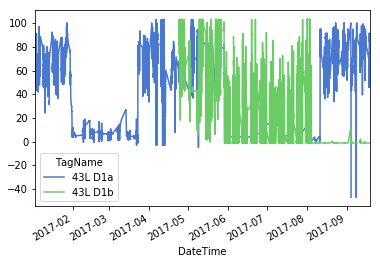

In [7]:
df[['43L D1a','43L D1b']].plot()
# use a

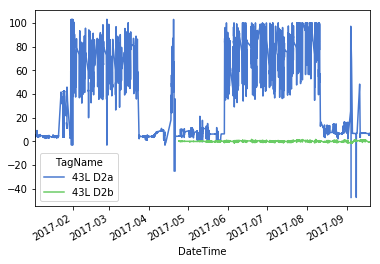

In [8]:
df[['43L D2a','43L D2b']].plot()
# use a

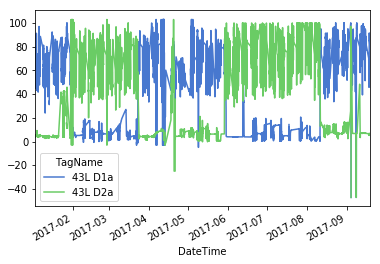

In [9]:
df[['43L D1a','43L D2a']].plot()

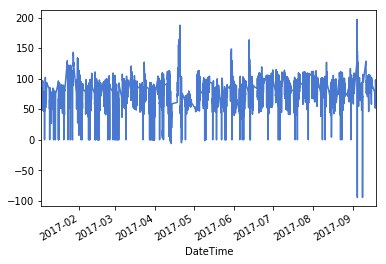

In [10]:
df[['43L D1a','43L D2a']].sum(axis=1).plot()

## Process selected data

In [11]:
df['44L Total pumps'] = df[[c for c in df.columns if '44L P' in c]].sum(axis=1, skipna=False)
df['44L Level'] = df[['43L D1a', '43L D2a']].sum(axis=1)  # new percentage on 10 ML, but 5 ML
df.drop(['30L D2', '43L D1a', '43L D2a', '43L D1b', '43L D2b', '30L D1', 'Flow to K1'], axis=1, inplace=True)

In [12]:
df.head()

TagName              Flow from 43L  44L P1  44L P2  44L P3  44L P4   Time_30  \
DateTime                                                                       
2017-01-03 00:00:00     276.329897     1.0     1.0     0.0     0.0  00:00:00   
2017-01-03 00:01:00     276.667415     NaN     NaN     NaN     NaN  00:00:00   
2017-01-03 00:02:00     277.123861     1.0     1.0     0.0     0.0  00:00:00   
2017-01-03 00:03:00     276.717341     1.0     1.0     0.0     0.0  00:00:00   
2017-01-03 00:04:00     277.537946     1.0     1.0     0.0     0.0  00:00:00   

TagName              EskomDayOfWeek  44L Total pumps  44L Level  
DateTime                                                         
2017-01-03 00:00:00               2              2.0  84.490692  
2017-01-03 00:01:00               2              NaN  84.313578  
2017-01-03 00:02:00               2              2.0  83.956628  
2017-01-03 00:03:00               2              2.0  83.795212  
2017-01-03 00:04:00               2              2.0  83.381342

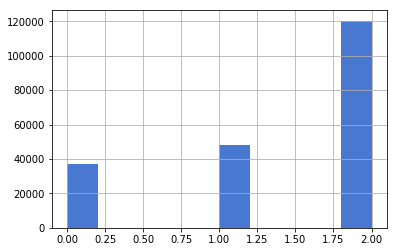

In [13]:
df['44L Total pumps'].hist()

In [14]:
flow_per_pump_if_1_run = df[df['44L Total pumps'] == 1]['Flow from 43L'].mean()
flow_per_pump_if_2_run = df[df['44L Total pumps'] == 2]['Flow from 43L'].mean()/2
count_per_pump_if_1_run = df[df['44L Total pumps'] == 1]['Flow from 43L'].count()
count_per_pump_if_2_run = df[df['44L Total pumps'] == 2]['Flow from 43L'].count()

print('Average flow per pump if one running = {:.1f} L/s'.format(flow_per_pump_if_1_run))
print('Average flow per pump if two running = {:.1f} L/s'.format(flow_per_pump_if_2_run))
ans = (flow_per_pump_if_1_run*count_per_pump_if_1_run + flow_per_pump_if_2_run*count_per_pump_if_2_run) / (count_per_pump_if_1_run+count_per_pump_if_2_run)
print('Weighted average flow per pump = {:.1f} L/s'.format(ans))
ans = float('{:.1f}'.format(ans))
print(ans)

Average flow per pump if one running = 168.7 L/s
Average flow per pump if two running = 133.0 L/s
Weighted average flow per pump = 143.0 L/s
143.0


In [15]:
def calculate_inflows(level_name, pump_flowrates, capacity, feeding_level_name=None):
    # feeding_level_name is the level feeding this level
    
    number_of_pumps = len(pump_flowrates)

    calc_pump_flows = [np.nan]
    calc_inflows = [np.nan]

    for i in range(1, len(df.index)):
        pump_status = {}
        for j,_ in enumerate(pump_flowrates):
            pump_str = 'P' + str(j+1)
            pump_status[pump_str] = df[level_name + ' ' + pump_str].values[i]
        
        l_new = df[level_name + ' Level'].values[i]
        l_old = df[level_name + ' Level'].values[i-1]
        pump_flow_from_prev_lev = 0 if feeding_level_name is None else df[feeding_level_name + ' PumpFlow'].values[i]
        
        if np.isnan([v for k,v in pump_status.items()] + [l_new] + [l_old] + [pump_flow_from_prev_lev]).any():
            ans_pumpflow = np.nan
            ans_inflow = np.nan

        delta_level = l_new - l_old
        if delta_level != 0:
            ans_outflow_pumps = 0
            for ps, pf in zip(pump_status.items(), pump_flowrates):
                ans_outflow_pumps += ps[1] * pf
                
            ans_inflow = ((l_new - l_old) / 100 * capacity) / 60 + ans_outflow_pumps - pump_flow_from_prev_lev
        else:
            ans_outflow_pumps = np.nan
            ans_inflow = np.nan

        calc_pump_flows.append(ans_outflow_pumps)
        calc_inflows.append(ans_inflow)

    df[level_name + ' PumpFlow'] = calc_pump_flows
    df[level_name + ' Inflow'] = calc_inflows

In [16]:
calculate_inflows('44L', [ans]*4, 5000000)

In [17]:
df.head()

TagName              Flow from 43L  44L P1  44L P2  44L P3  44L P4   Time_30  \
DateTime                                                                       
2017-01-03 00:00:00     276.329897     1.0     1.0     0.0     0.0  00:00:00   
2017-01-03 00:01:00     276.667415     NaN     NaN     NaN     NaN  00:00:00   
2017-01-03 00:02:00     277.123861     1.0     1.0     0.0     0.0  00:00:00   
2017-01-03 00:03:00     276.717341     1.0     1.0     0.0     0.0  00:00:00   
2017-01-03 00:04:00     277.537946     1.0     1.0     0.0     0.0  00:00:00   

TagName              EskomDayOfWeek  44L Total pumps  44L Level  44L PumpFlow  \
DateTime                                                                        
2017-01-03 00:00:00               2              2.0  84.490692           NaN   
2017-01-03 00:01:00               2              NaN  84.313578           NaN   
2017-01-03 00:02:00               2              2.0  83.956628         286.0   
2017-01-03 00:03:00               2              2.0  83.795212         286.0   
2017-01-03 00:04:00               2              2.0  83.381342         286.0   

TagName              44L Inflow  
DateTime                         
2017-01-03 00:00:00         NaN  
2017-01-03 00:01:00         NaN  
2017-01-03 00:02:00  -11.458425  
2017-01-03 00:03:00  151.486670  
2017-01-03 00:04:00  -58.891881

## Inflow profile

In [18]:
df2 = df.copy()

date_start = '2017-05-31'
date_end = '2017-06-01'

df2 = df2[(df2.index>=date_start) & (df2.index<date_end)]

inflow_profiles = []
overall_day_completeness_count = 0
overall_day_completeness_max = 0
overall_completeness_count = 0
overall_completeness_max = 0
for l in ['44L']:
    grouped = df2.set_index('Time_30')[l + ' Inflow'].groupby('Time_30')
    
    grouped_mean = grouped.mean()
    inflow_profiles.append(grouped_mean)
    
    print('{} completeness: {:6.2f}% → {:6.2f}%'.format(l, grouped.count().sum()/48/30*100, grouped_mean.count()/48*100))#grouped.count()/30
    overall_day_completeness_count += grouped.count().sum()
    overall_day_completeness_max += 48*30
    overall_completeness_count += grouped_mean.count()
    overall_completeness_max += 48
print('                   ------   -------')
print('All completenes:  {:6.2f}% → {:6.2f}%'.format(overall_day_completeness_count/overall_day_completeness_max*100, overall_completeness_count/overall_completeness_max*100))
    
pd.DataFrame(inflow_profiles).T.to_csv('..\..\simulations\K3\input\K3_dam_inflow_profiles.csv.gz', compression='gzip')

44L completeness: 100.00% → 100.00%
                   ------   -------
All completenes:  100.00% → 100.00%


## Data for verification of the simulation

In [19]:
df_real = pd.read_csv('K3 data 1s 05-31_2017-09-27_pivot.csv.gz')
df_real = df_real.set_index('DateTime')
df_real.index = pd.to_datetime(df_real.index)
df_real.head()

KDCE_S03_30INS00_00IFT#501.FA_PV  \
DateTime                                                
2017-05-31 00:00:00                        260.783131   
2017-05-31 00:00:01                        260.949493   
2017-05-31 00:00:02                        261.012313   
2017-05-31 00:00:03                        261.015103   
2017-05-31 00:00:04                        260.776504   

                     KDCE_S03_30INS00_00ILT#501.FA_PV  \
DateTime                                                
2017-05-31 00:00:00                         36.701481   
2017-05-31 00:00:01                         36.701481   
2017-05-31 00:00:02                         36.701481   
2017-05-31 00:00:03                         36.701481   
2017-05-31 00:00:04                         36.633303   

                     KDCE_S03_43INS00_00ILT#503.FA_PV  \
DateTime                                                
2017-05-31 00:00:00                          4.192639   
2017-05-31 00:00:01                          4.192639   
2017-05-31 00:00:02                          4.192639   
2017-05-31 00:00:03                          4.192639   
2017-05-31 00:00:04                          4.192639   

                     KDCE_S03_43INS00_00ILT#504.FA_PV  \
DateTime                                                
2017-05-31 00:00:00                         71.770134   
2017-05-31 00:00:01                         71.770134   
2017-05-31 00:00:02                         71.681156   
2017-05-31 00:00:03                         71.679736   
2017-05-31 00:00:04                         71.753052   

                     KDCE_S03_44PMP01_Machine.FA_RF  \
DateTime                                              
2017-05-31 00:00:00                             0.0   
2017-05-31 00:00:01                             0.0   
2017-05-31 00:00:02                             0.0   
2017-05-31 00:00:03                             0.0   
2017-05-31 00:00:04                             0.0   

                     KDCE_S03_44PMP02_Machine.FA_RF  \
DateTime                                              
2017-05-31 00:00:00                             1.0   
2017-05-31 00:00:01                             1.0   
2017-05-31 00:00:02                             1.0   
2017-05-31 00:00:03                             1.0   
2017-05-31 00:00:04                             1.0   

                     KDCE_S03_44PMP03_Machine.FA_RF  \
DateTime                                              
2017-05-31 00:00:00                             0.0   
2017-05-31 00:00:01                             0.0   
2017-05-31 00:00:02                             0.0   
2017-05-31 00:00:03                             0.0   
2017-05-31 00:00:04                             0.0   

                     KDCE_S03_44PMP04_Machine.FA_RF  
DateTime                                             
2017-05-31 00:00:00                             1.0  
2017-05-31 00:00:01                             1.0  
2017-05-31 00:00:02                             1.0  
2017-05-31 00:00:03                             1.0  
2017-05-31 00:00:04                             1.0

In [20]:
df_real = df_real.rename(columns = {'KDCE_S03_30INS00_00ILT#501.FA_PV': '30L D1',
                                    'KDCE_S03_43INS00_00ILT#503.FA_PV': '43L D1a',
                                    'KDCE_S03_43INS00_00ILT#504.FA_PV': '43L D2a',
                                    'KDCE_S03_30INS00_00IFT#501.FA_PV': 'Flow from 43L'})

status_col_dict = {}
for c in df_real.columns:
    if '_Machine.FA_RF' in c: # pump status
        item = c.split('_')[2].split('PMP')
        level = item[0] + 'L'
        pump_num = 'P' + item[1][1]
        status_col_dict[c] = level + ' ' + pump_num
df_real = df_real.rename(columns = status_col_dict)

df_real['44L Status'] = df_real[[c for c in df_real.columns if '44L P' in c]].sum(axis=1, skipna=False)

df_real = df_real.rename(columns = {'30L D1': '30L Level'})
df_real['44L Level'] = df_real[['43L D1a', '43L D2a']].sum(axis=1)  # new percentage on 10 ML

df_real.drop(['43L D1a', '43L D2a', 'Flow from 43L', '30L Level'], axis=1, inplace=True)

df_real.head()

44L P1  44L P2  44L P3  44L P4  44L Status  44L Level
DateTime                                                                  
2017-05-31 00:00:00     0.0     1.0     0.0     1.0         2.0  75.962773
2017-05-31 00:00:01     0.0     1.0     0.0     1.0         2.0  75.962773
2017-05-31 00:00:02     0.0     1.0     0.0     1.0         2.0  75.873795
2017-05-31 00:00:03     0.0     1.0     0.0     1.0         2.0  75.872375
2017-05-31 00:00:04     0.0     1.0     0.0     1.0         2.0  75.945691

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


Data completeness: 1.0


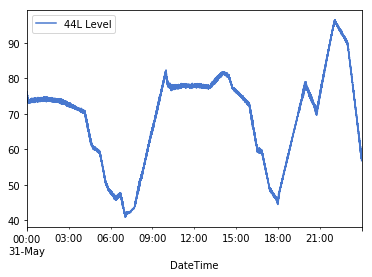

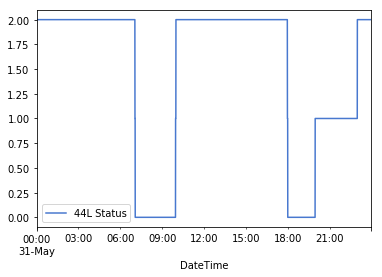

In [21]:
date_range_start = '2017-05-31'
date_range_end = '2017-06-01'

level_list = ['44L']
level_tag_list = [l + ' Level' for l in level_list]
status_tag_list = [l + ' Status' for l in level_list]
tag_list = level_tag_list + status_tag_list

df_real2 = df_real.ix[date_range_start:date_range_end]

print('Data completeness:', df_real2[tag_list].count(axis=0).sum()/(2 * 60*60*24))

df_real2[level_tag_list].plot()
df_real2[status_tag_list].plot()

In [22]:
df_real2['44L Status'] = df_real2['44L Status'].interpolate('pchip')
df_real2['44L Level'] = df_real2['44L Level'].interpolate('pchip')

#### Save simulation testing data

In [23]:
df_real2[['44L Status', '44L Level']].to_csv('..\..\simulations\K3\input\K3_data_for_verification.csv.gz', compression='gzip')

# Now perform the simulation in verification mode

**If the simulation outputs are reasonably "the same" as the real data, the simulation is "correct"**

In [24]:
df_sim = pd.read_csv('..\..\simulations\K3\output\K3_simulation_data_export_verification.csv.gz')

df_sim['time_clean'] = pd.to_datetime(df_sim['seconds'], unit='s') + timedelta(days=17317)
df_sim.head()

seconds  44L Level  44L Status  Eskom ToU  Pump system total power  \
0        0  75.962773         2.0          3                   3800.0   
1        1  75.961277         2.0          3                   3800.0   
2        2  75.959780         2.0          3                   3800.0   
3        3  75.958283         2.0          3                   3800.0   
4        4  75.956786         2.0          3                   3800.0   

           time_clean  
0 2017-05-31 00:00:00  
1 2017-05-31 00:00:01  
2 2017-05-31 00:00:02  
3 2017-05-31 00:00:03  
4 2017-05-31 00:00:04

In [25]:
def rmse(real, sim):
    return np.sqrt(((real - sim) ** 2).mean())

def r2(x, y):
    return stats.pearsonr(x,y)[0] ** 2

## Comparison of simulation and actual data

### 44L pump status

In [26]:
x = pd.to_datetime(df_real2.index.values).time
y1 = df_real2['44L Status'].values
y2 = df_sim['44L Status'].values

print('R squared = ', r2(y1, y2))
print('RMSE = ', rmse(y1, y2))

R squared =  1.0
RMSE =  0.0


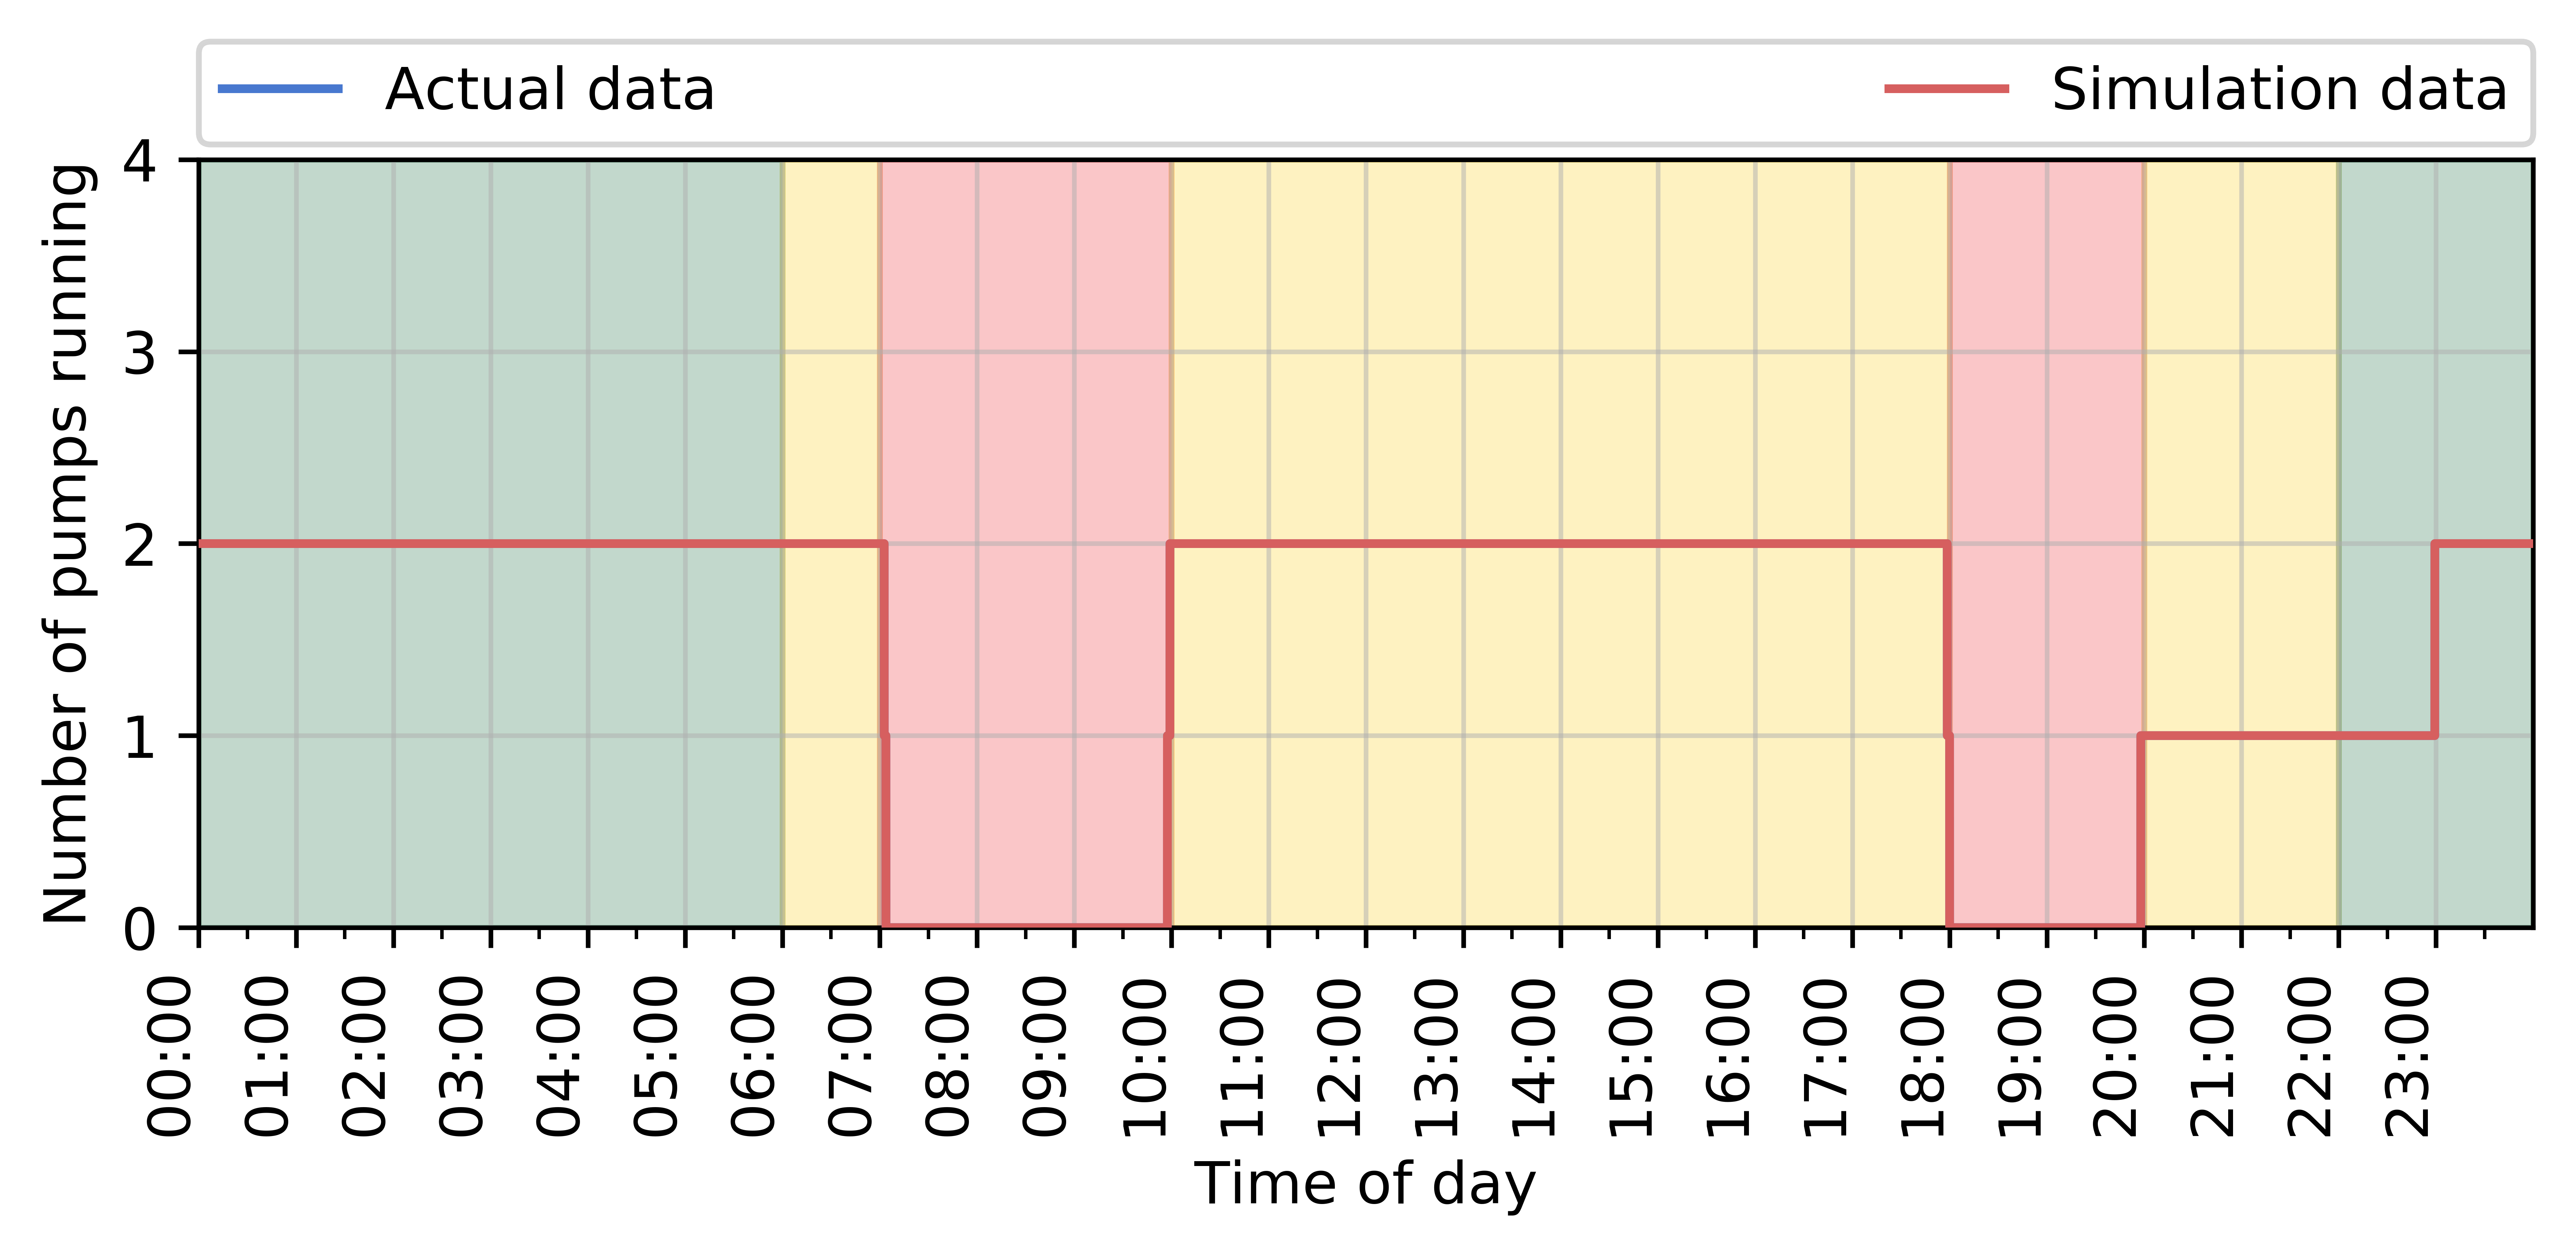

In [27]:
fig, ax1 = plt.subplots(figsize=(figure_size[0], figure_size[1]/1.5), dpi=1200)

x = df_sim['time_clean']

ax1.plot(x, df_real2['44L Status'], marker=None, label='Actual data', zorder=10)
ax1.plot(x, df_sim['44L Status'], marker=None, label='Simulation data', zorder=11, color=sns.color_palette('muted')[2])

ax1.set_xlabel('Time of day')
ax1.set_ylabel('Number of pumps running')
ax1.set_ylim([0, 4])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.axvspan('2017-05-31 00:00:00','2017-05-31 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('2017-05-31 06:00:00','2017-05-31 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('2017-05-31 07:00:00','2017-05-31 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('2017-05-31 10:00:00','2017-05-31 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('2017-05-31 18:00:00','2017-05-31 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('2017-05-31 20:00:00','2017-05-31 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('2017-05-31 22:00:00','2017-05-31 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x),max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)

fig.tight_layout()
plt.show()

fig.savefig('output/k3_verification_44l_status.png', bbox_inches='tight')

plt.close('all')

### 44L dam level

In [28]:
x = pd.to_datetime(df_real2.index.values).time
y1 = df_real2['44L Level'].values
y2 = df_sim['44L Level'].values

print('R squared = ', r2(y1, y2))
print('RMSE = ', rmse(y1, y2))

R squared =  0.996373742526
RMSE =  1.24991693065


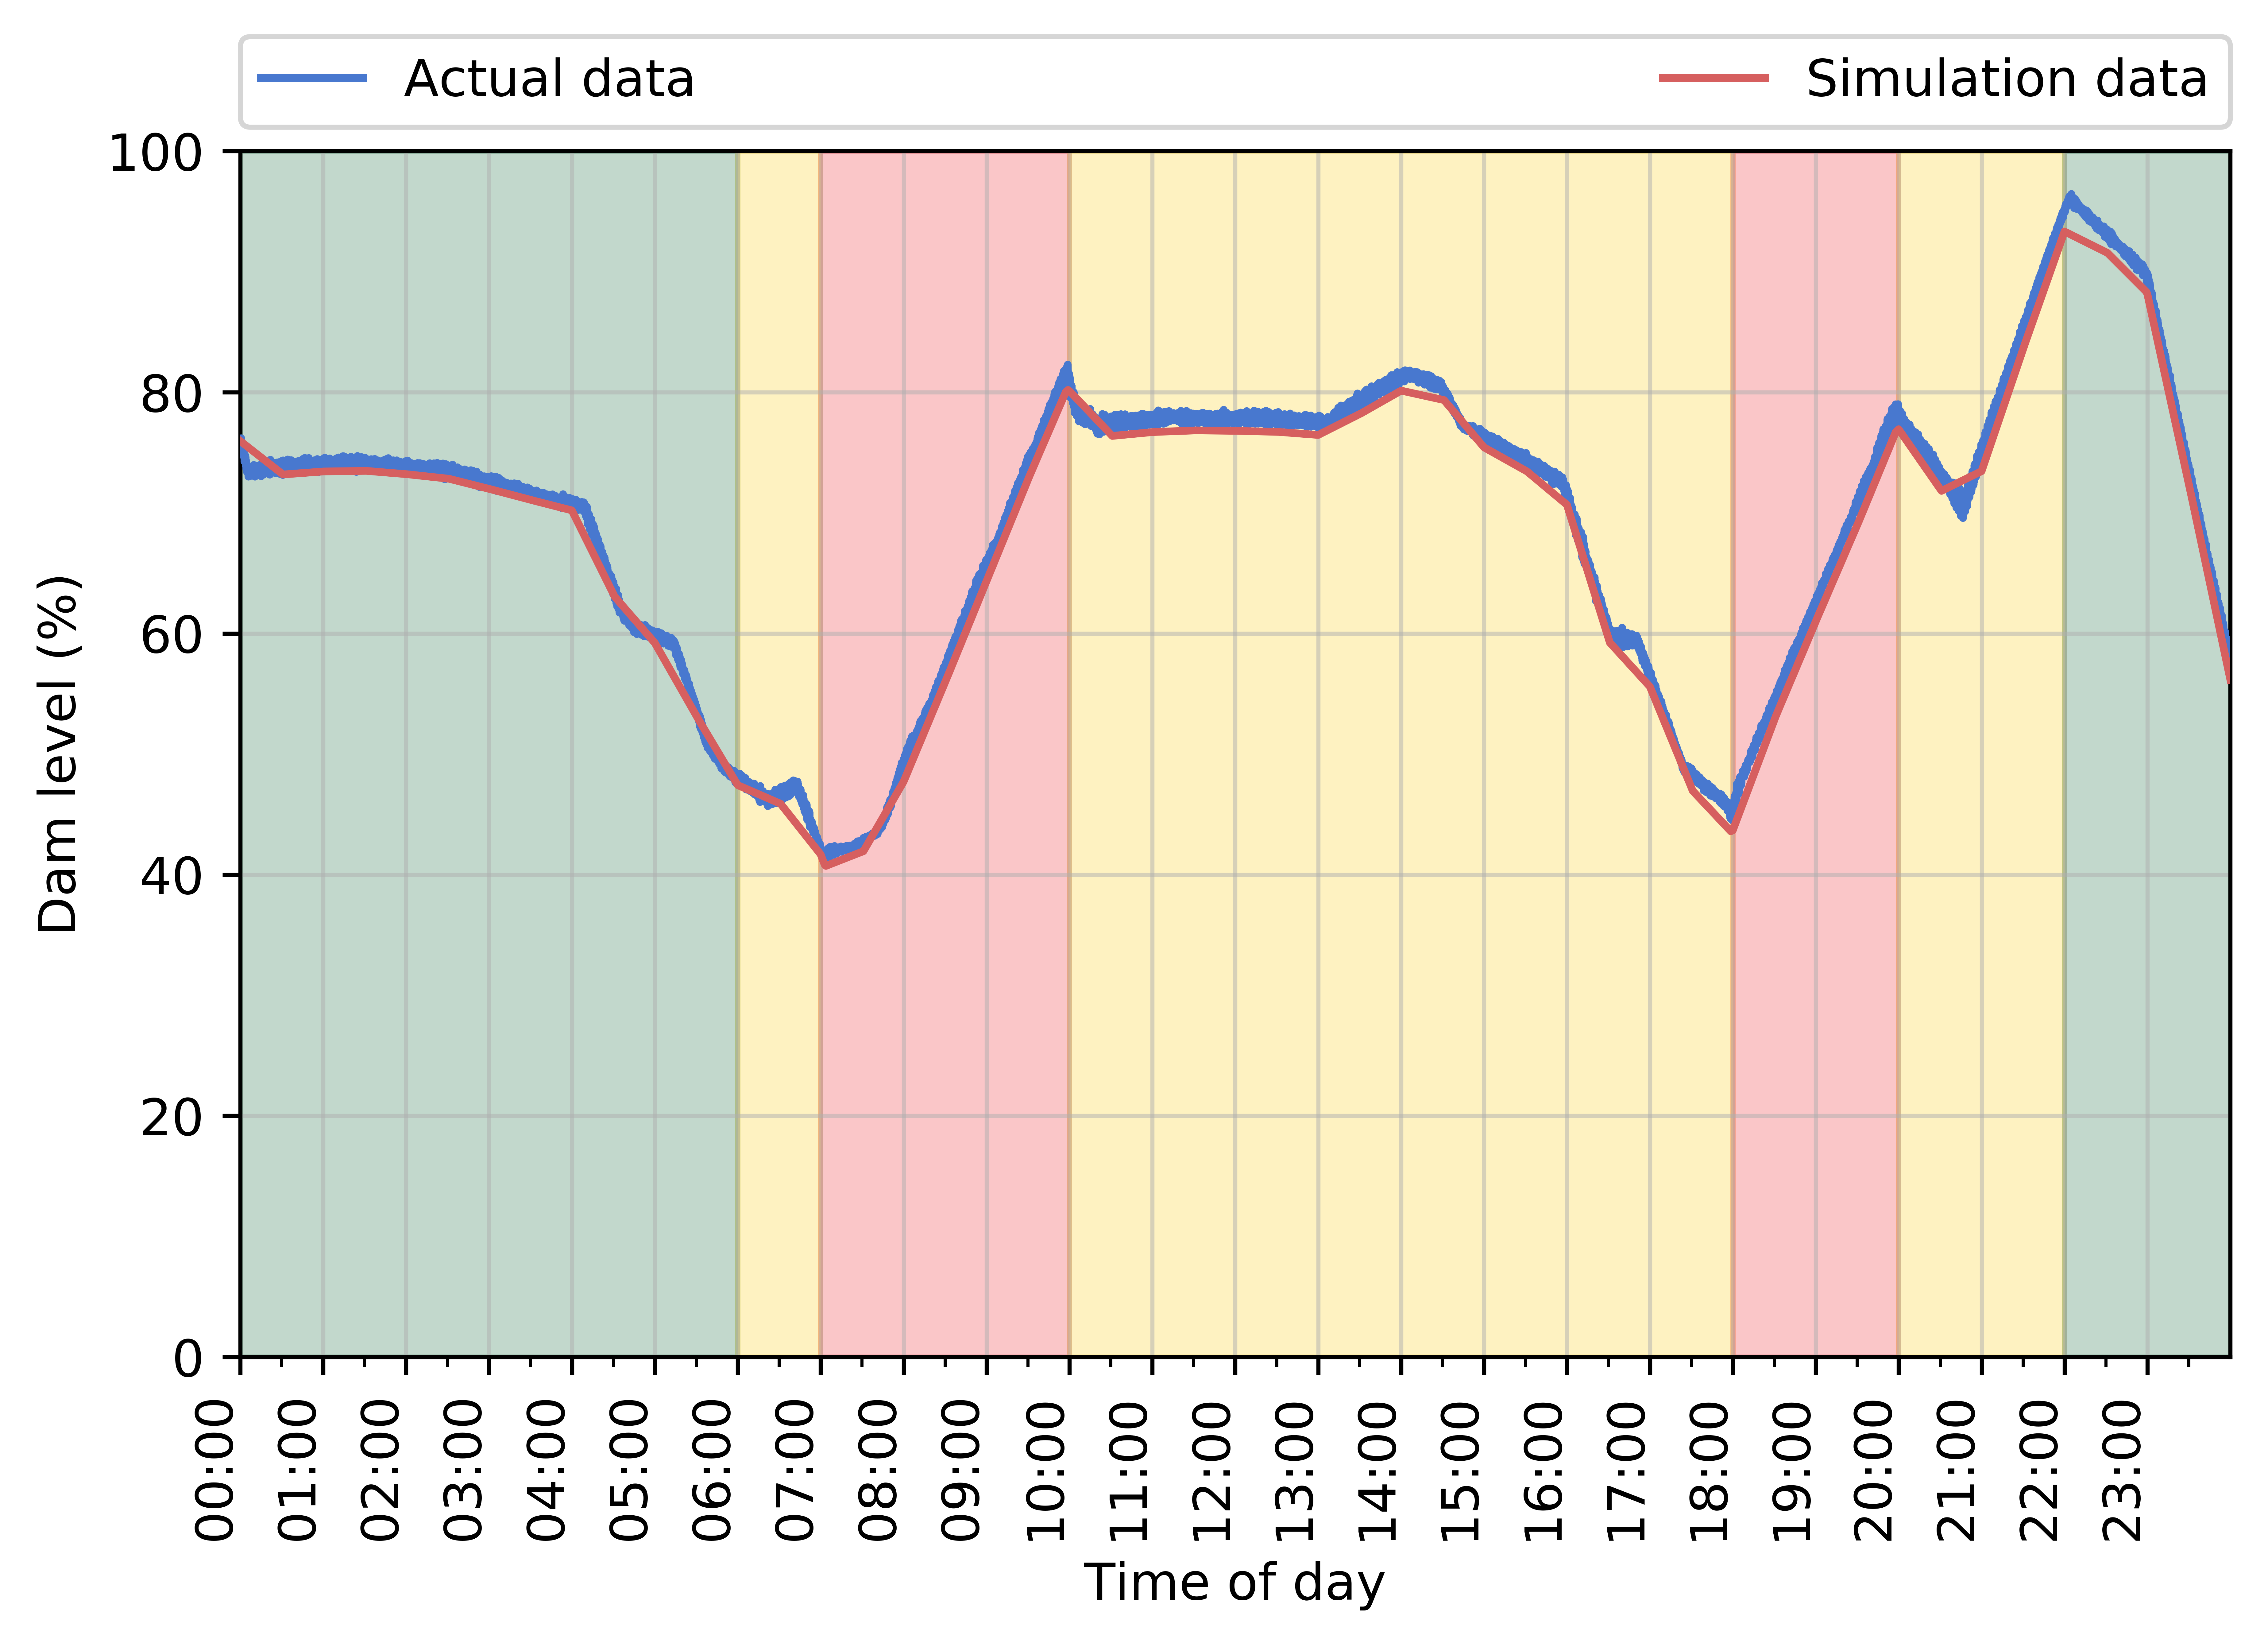

In [29]:
fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)

x = df_sim['time_clean']

ax1.plot(x, df_real2['44L Level'], marker=None, label='Actual data', zorder=10)
ax1.plot(x, df_sim['44L Level'], marker=None, label='Simulation data', zorder=11, color=sns.color_palette('muted')[2])

ax1.set_xlabel('Time of day')
ax1.set_ylabel('Dam level (%)')
ax1.set_ylim([0, 100])

ax1.axvspan('2017-05-31 00:00:00','2017-05-31 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('2017-05-31 06:00:00','2017-05-31 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('2017-05-31 07:00:00','2017-05-31 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('2017-05-31 10:00:00','2017-05-31 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('2017-05-31 18:00:00','2017-05-31 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('2017-05-31 20:00:00','2017-05-31 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('2017-05-31 22:00:00','2017-05-31 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x),max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)

fig.tight_layout()
plt.show()

fig.savefig('output/k3_verification_44l_level.png', bbox_inches='tight')

plt.close('all')

# Processing of x-factored simulation data

## 1-factor

In [30]:
df = pd.read_csv('..\..\simulations\K3\output\K3_simulation_data_export_1-factor.csv.gz')
df['time_clean'] = pd.to_datetime(df['seconds'], unit='s')
df.head()

seconds  44L Level  44L Status  Eskom ToU  Pump system total power  \
0        0  75.962773         2.0          3                   3800.0   
1        1  75.961277         2.0          3                   3800.0   
2        2  75.959780         2.0          3                   3800.0   
3        3  75.958283         2.0          3                   3800.0   
4        4  75.956786         2.0          3                   3800.0   

           time_clean  
0 1970-01-01 00:00:00  
1 1970-01-01 00:00:01  
2 1970-01-01 00:00:02  
3 1970-01-01 00:00:03  
4 1970-01-01 00:00:04

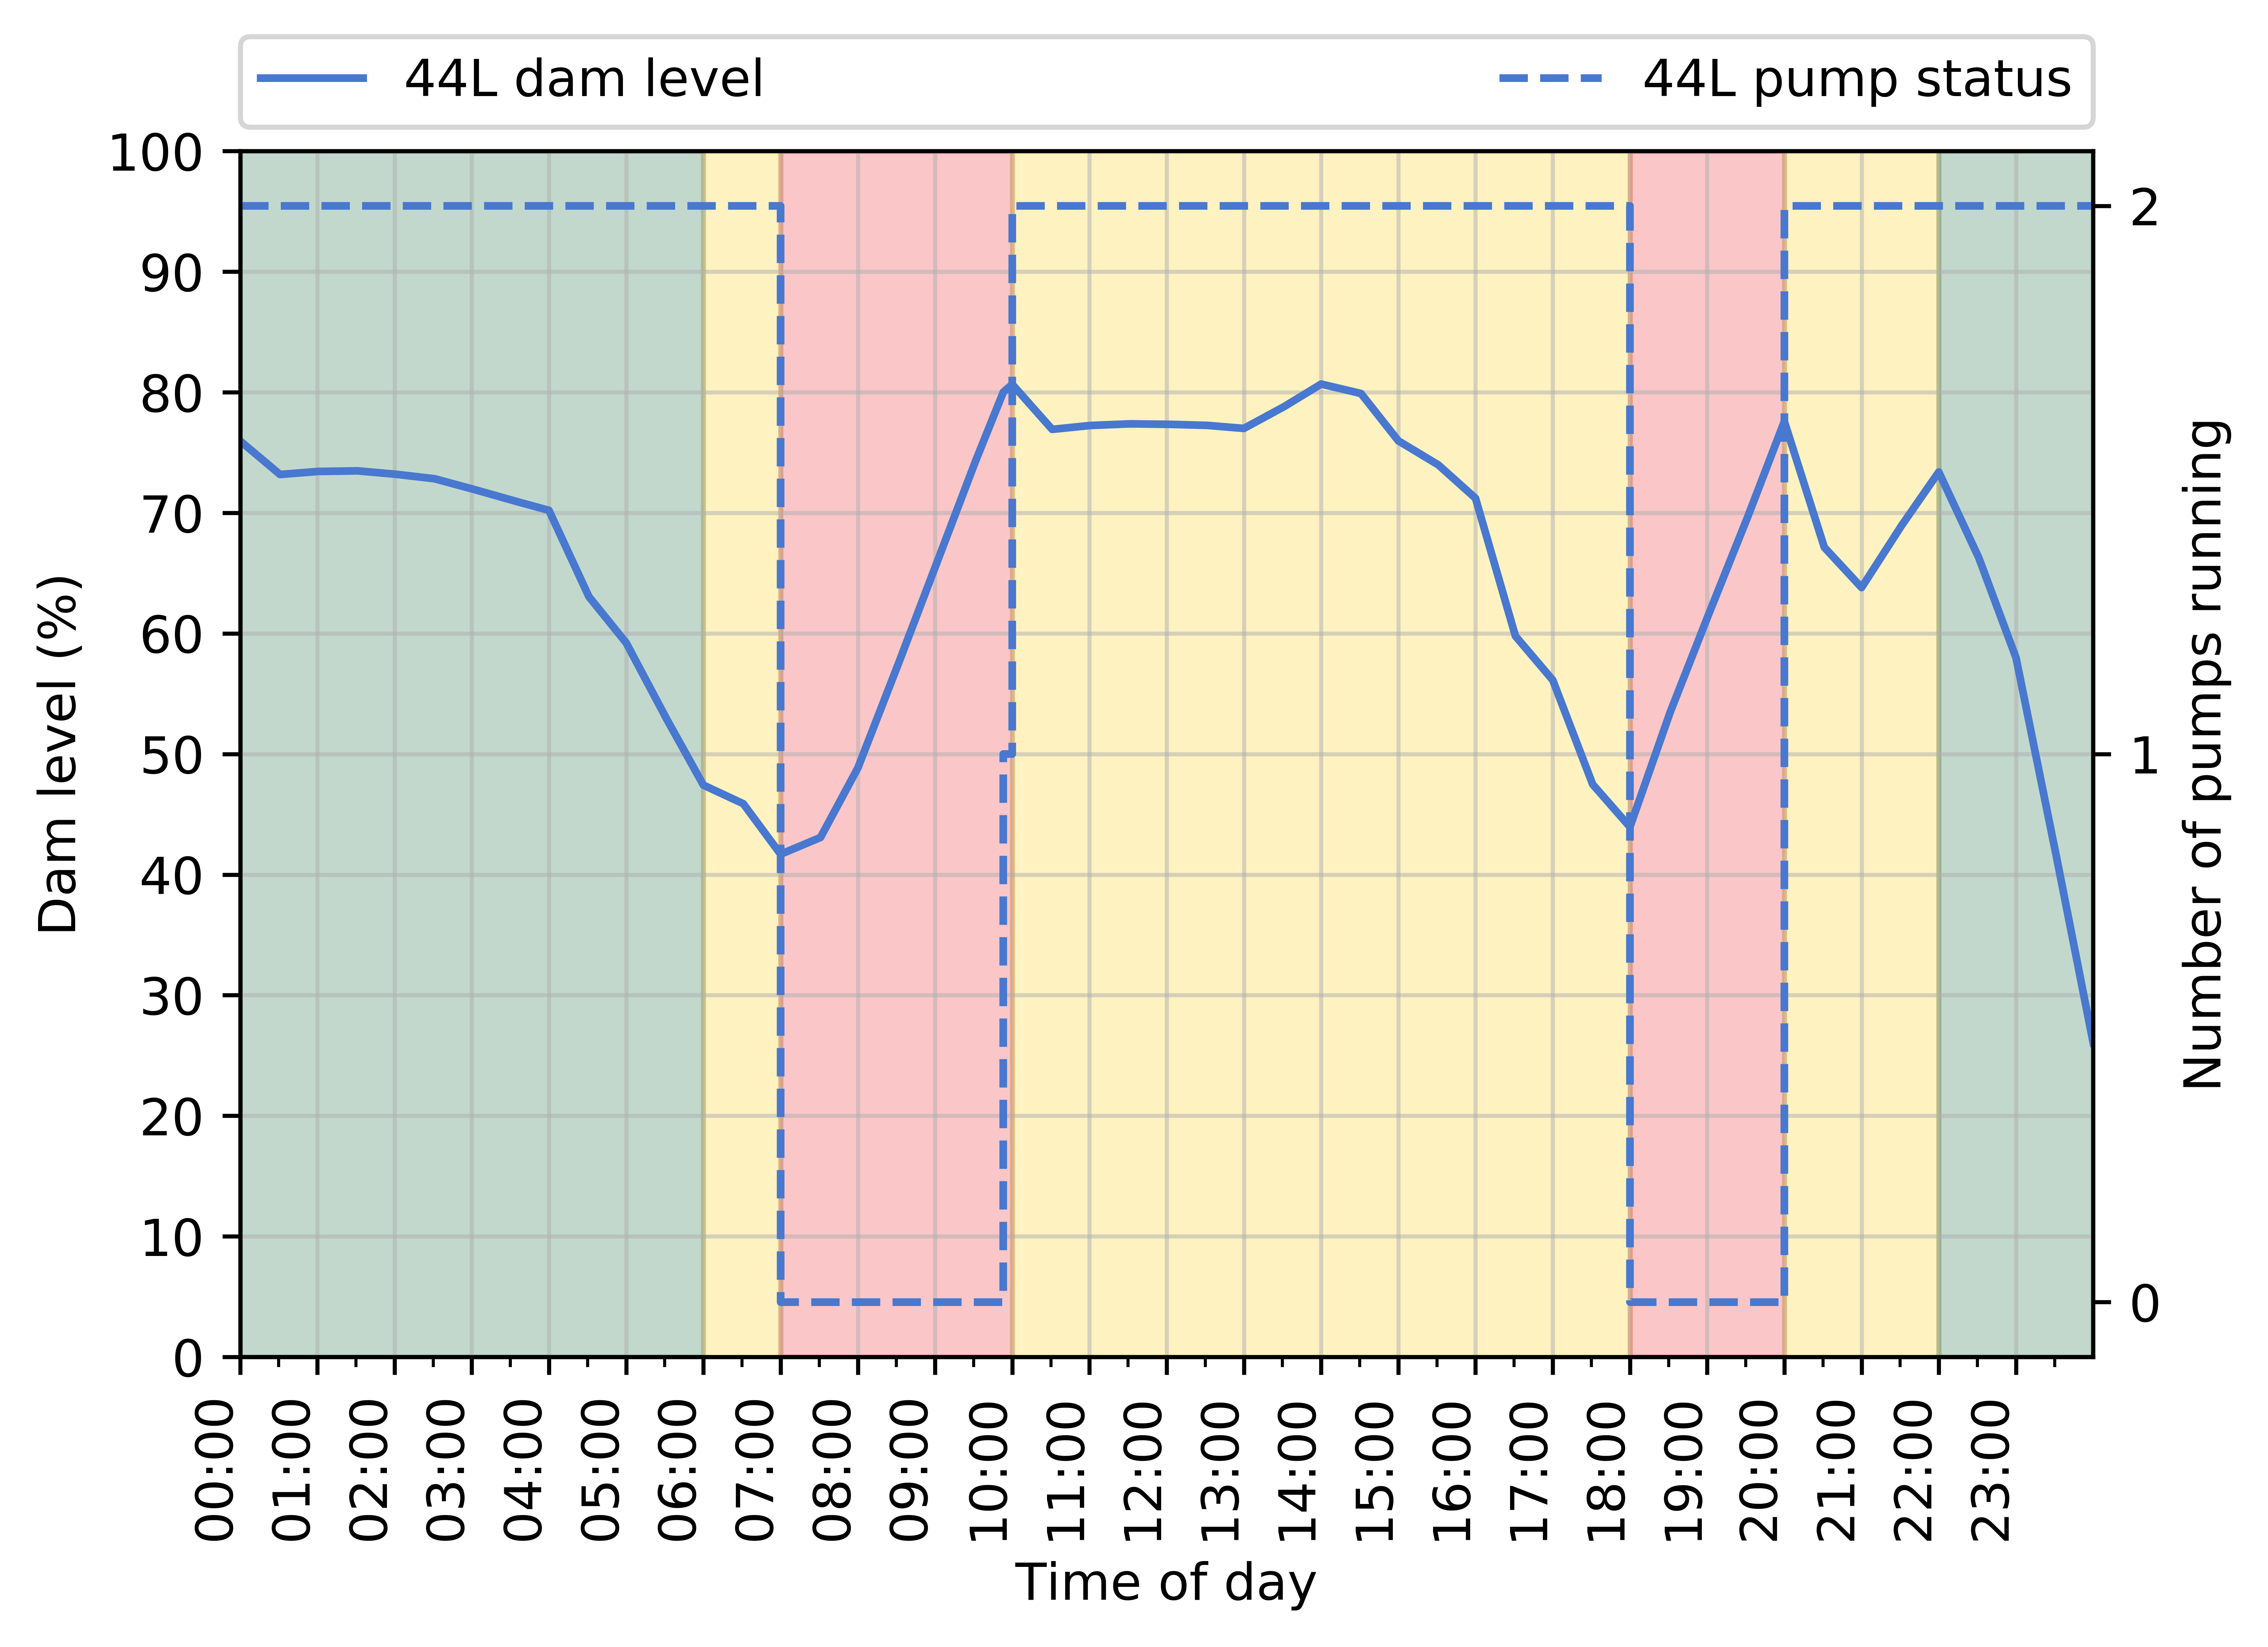

In [31]:
x = df['time_clean']

fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

lines1 = ax1.plot(x, df[[col for col in df.columns if 'level' in col.lower()]])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax2 = ax1.twinx()
lines2 = ax2.plot(x, df[[col for col in df.columns if 'Status' in col]], '--')

ax1.set_xlabel('Time of day')
ax1.set_ylabel('Dam level (%)')
ax1.set_ylim([0, 100])
ax2.set_ylabel('Number of pumps running')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_ticks(np.arange(0, 101, 10))
ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x), max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)
#ax2.grid(which='major', alpha=0.5)
#ax1.minorticks_on()

p = lines1 + lines2
plt.legend(p, ['44L dam level', '44L pump status'],
          bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)
#plt.legend(p,[p_.get_label() for subp in p for p_ in subp])

#plt.legend(lines1, ('a','b'), loc='best')
#plt.legend(lines2, ('c','d'), loc='best')

fig.tight_layout()
plt.show()

fig.savefig('output/k3_1_level_and_status.png', bbox_inches='tight')

plt.close('all')

### Plot power

#### Raw data

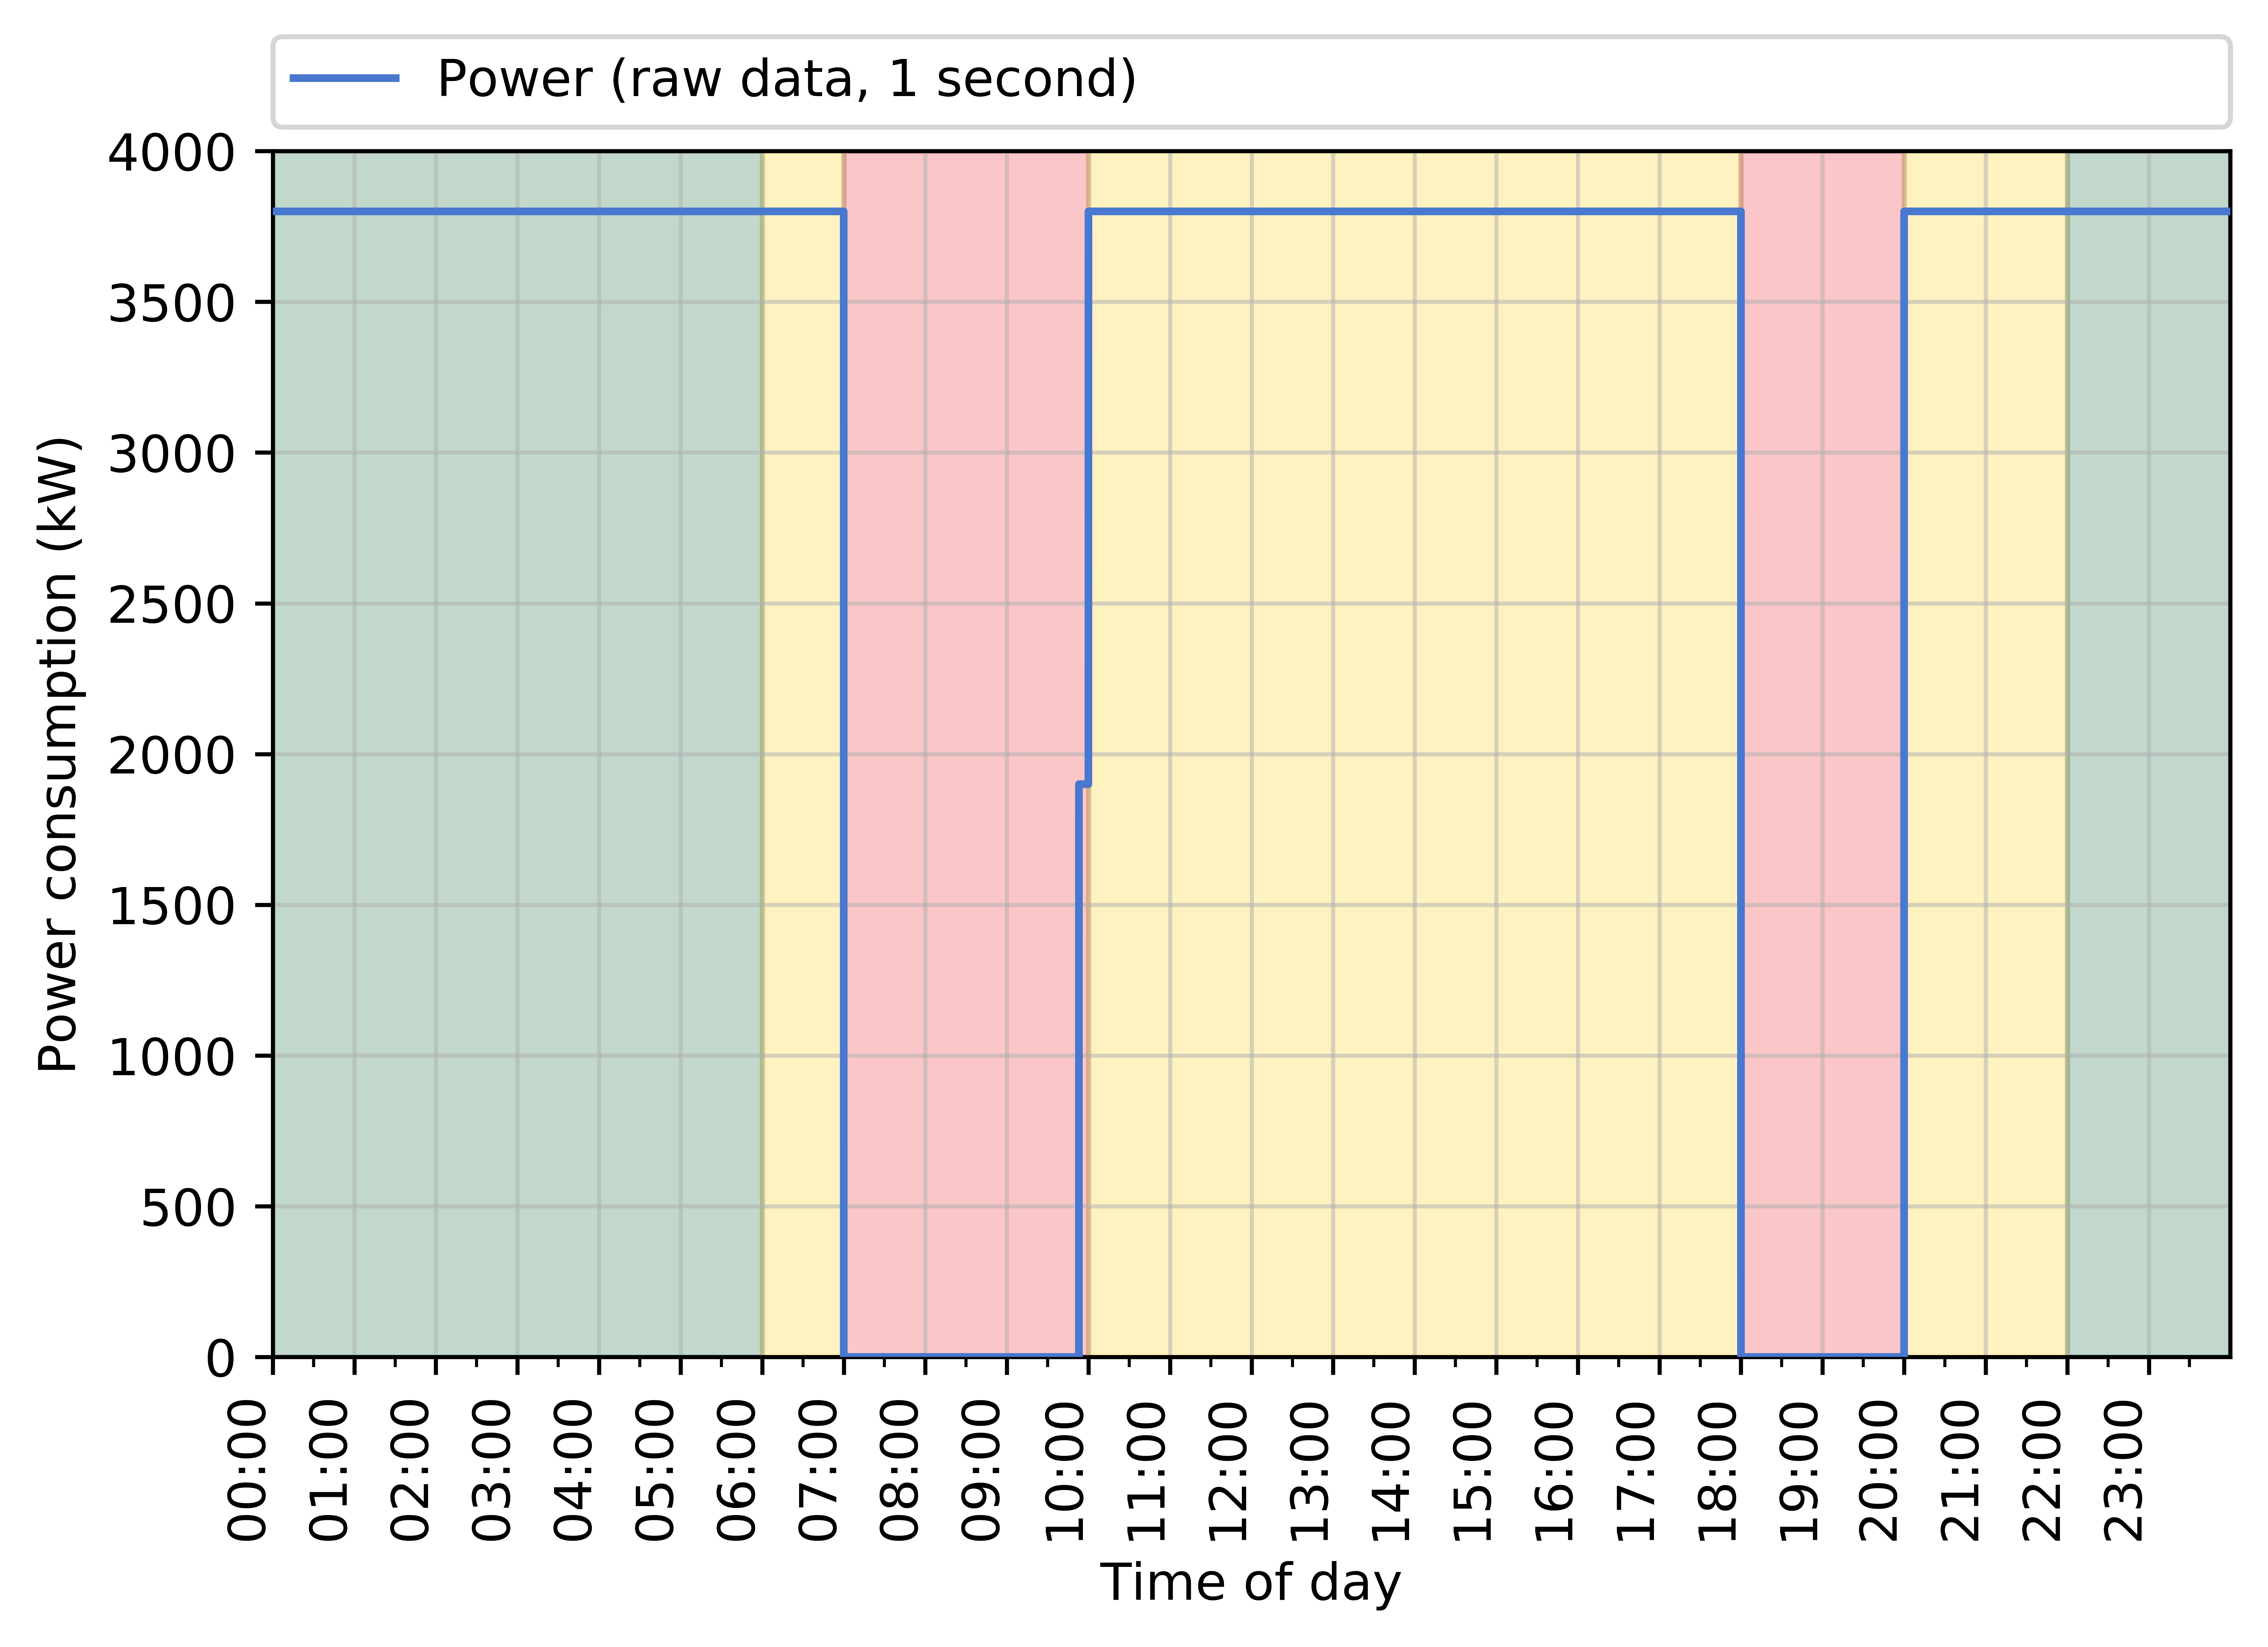

In [32]:
fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

ax1.plot(df['time_clean'], df['Pump system total power'], marker=None, label='Power (raw data, 1 second)', zorder=10)
ax1.set_xlabel('Time of day')
ax1.set_ylabel('Power consumption (kW)')
ax1.set_ylim([0, 4000])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x),max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)

fig.tight_layout()
plt.show()

fig.savefig('output/k3_1_power_raw.png', bbox_inches='tight')

plt.close('all')

#### Resampled data

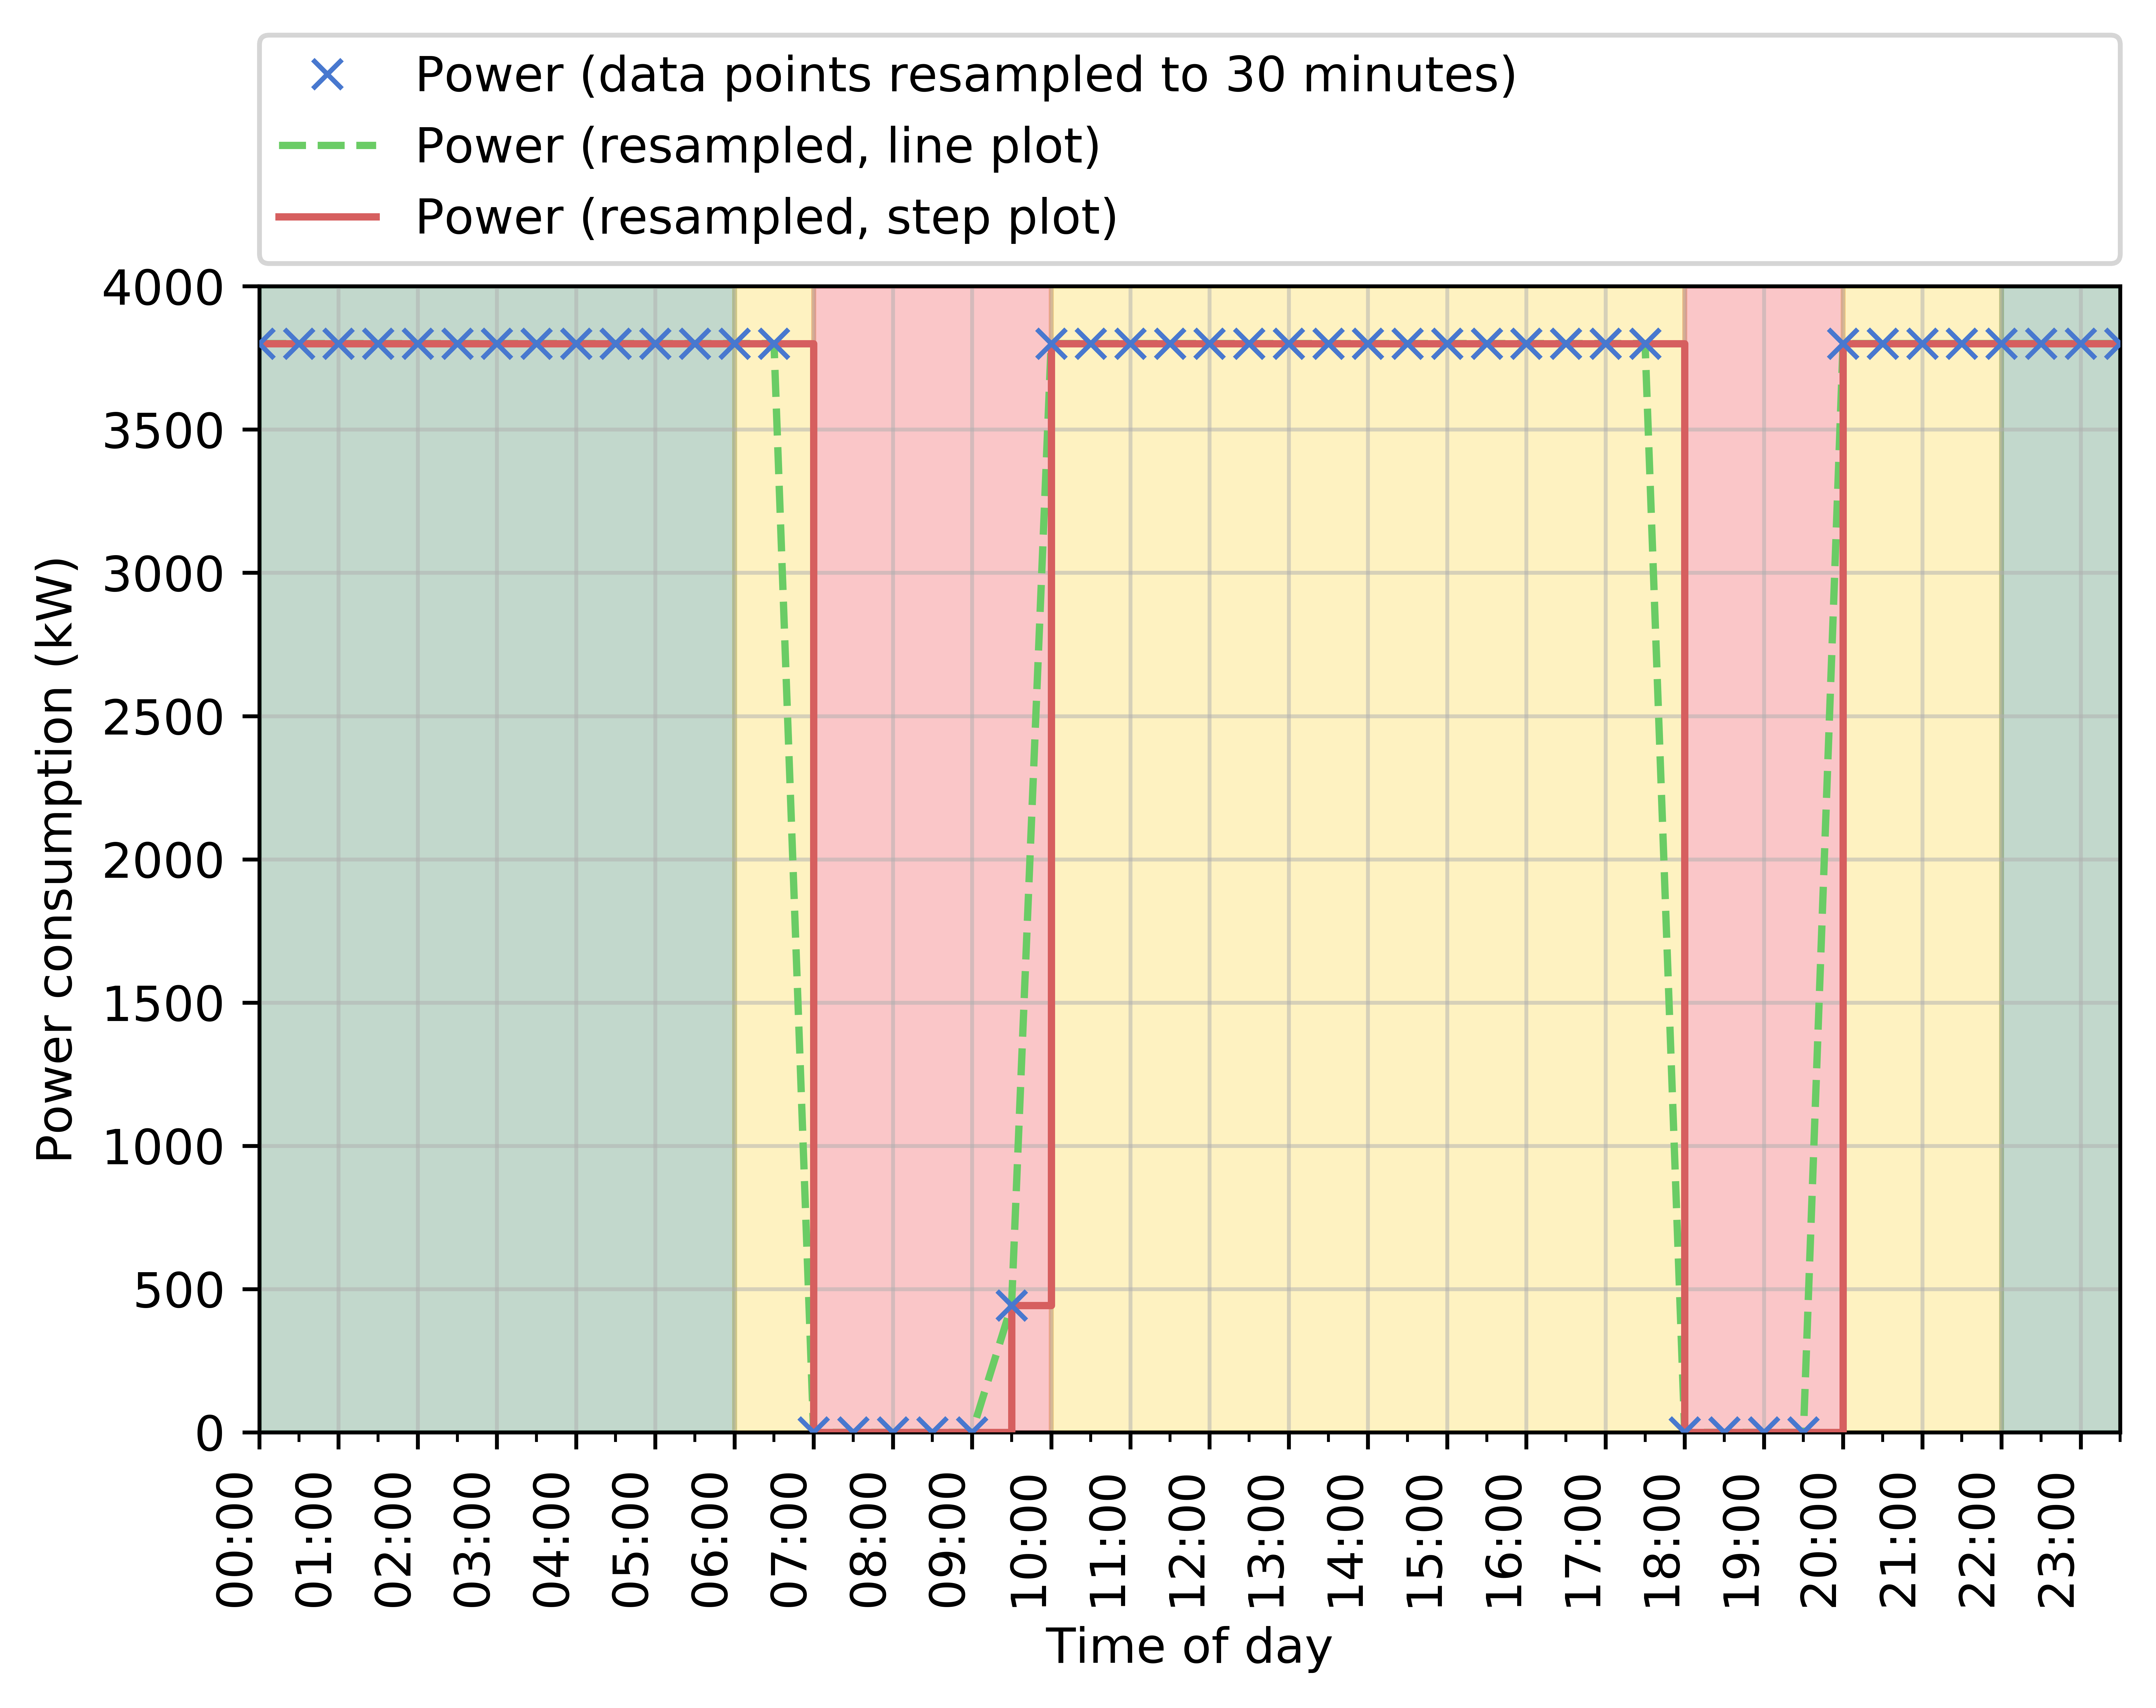

In [33]:
resampled = pd.DataFrame()
resampled['total_30_minute'] = df.set_index('time_clean')['Pump system total power'].resample('30T').mean()

resampled.to_csv('output/K3_resampled_power_1_factor.csv')

fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

x = resampled.index
y = resampled['total_30_minute']

ax1.plot(x,y, 'x', label='Power (data points resampled to 30 minutes)', zorder=4)
ax1.plot(x,y, '--', label='Power (resampled, line plot)', zorder=2)
ax1.plot(x,y, drawstyle='steps-post', label='Power (resampled, step plot)', zorder=3)
ax1.set_xlabel('Time of day')
ax1.set_ylabel('Power consumption (kW)')
ax1.set_ylim([0, 4000])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x),max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode='expand', borderaxespad=0.)

fig.tight_layout()
plt.show()

fig.savefig('output/k3_1_power_resampled.png', bbox_inches='tight'),

plt.close('all')

## 2-factor

In [34]:
df = pd.read_csv('..\..\simulations\K3\\output\K3_simulation_data_export_2-factor.csv.gz')
df['time_clean'] = pd.to_datetime(df['seconds'], unit='s')
df.head()

seconds  44L Level  44L Status  Eskom ToU  Pump system total power  \
0        0  75.962773         2.0          3                   3800.0   
1        1  75.961277         2.0          3                   3800.0   
2        2  75.959780         2.0          3                   3800.0   
3        3  75.958283         2.0          3                   3800.0   
4        4  75.956786         2.0          3                   3800.0   

           time_clean  
0 1970-01-01 00:00:00  
1 1970-01-01 00:00:01  
2 1970-01-01 00:00:02  
3 1970-01-01 00:00:03  
4 1970-01-01 00:00:04

### Plot dam level and status

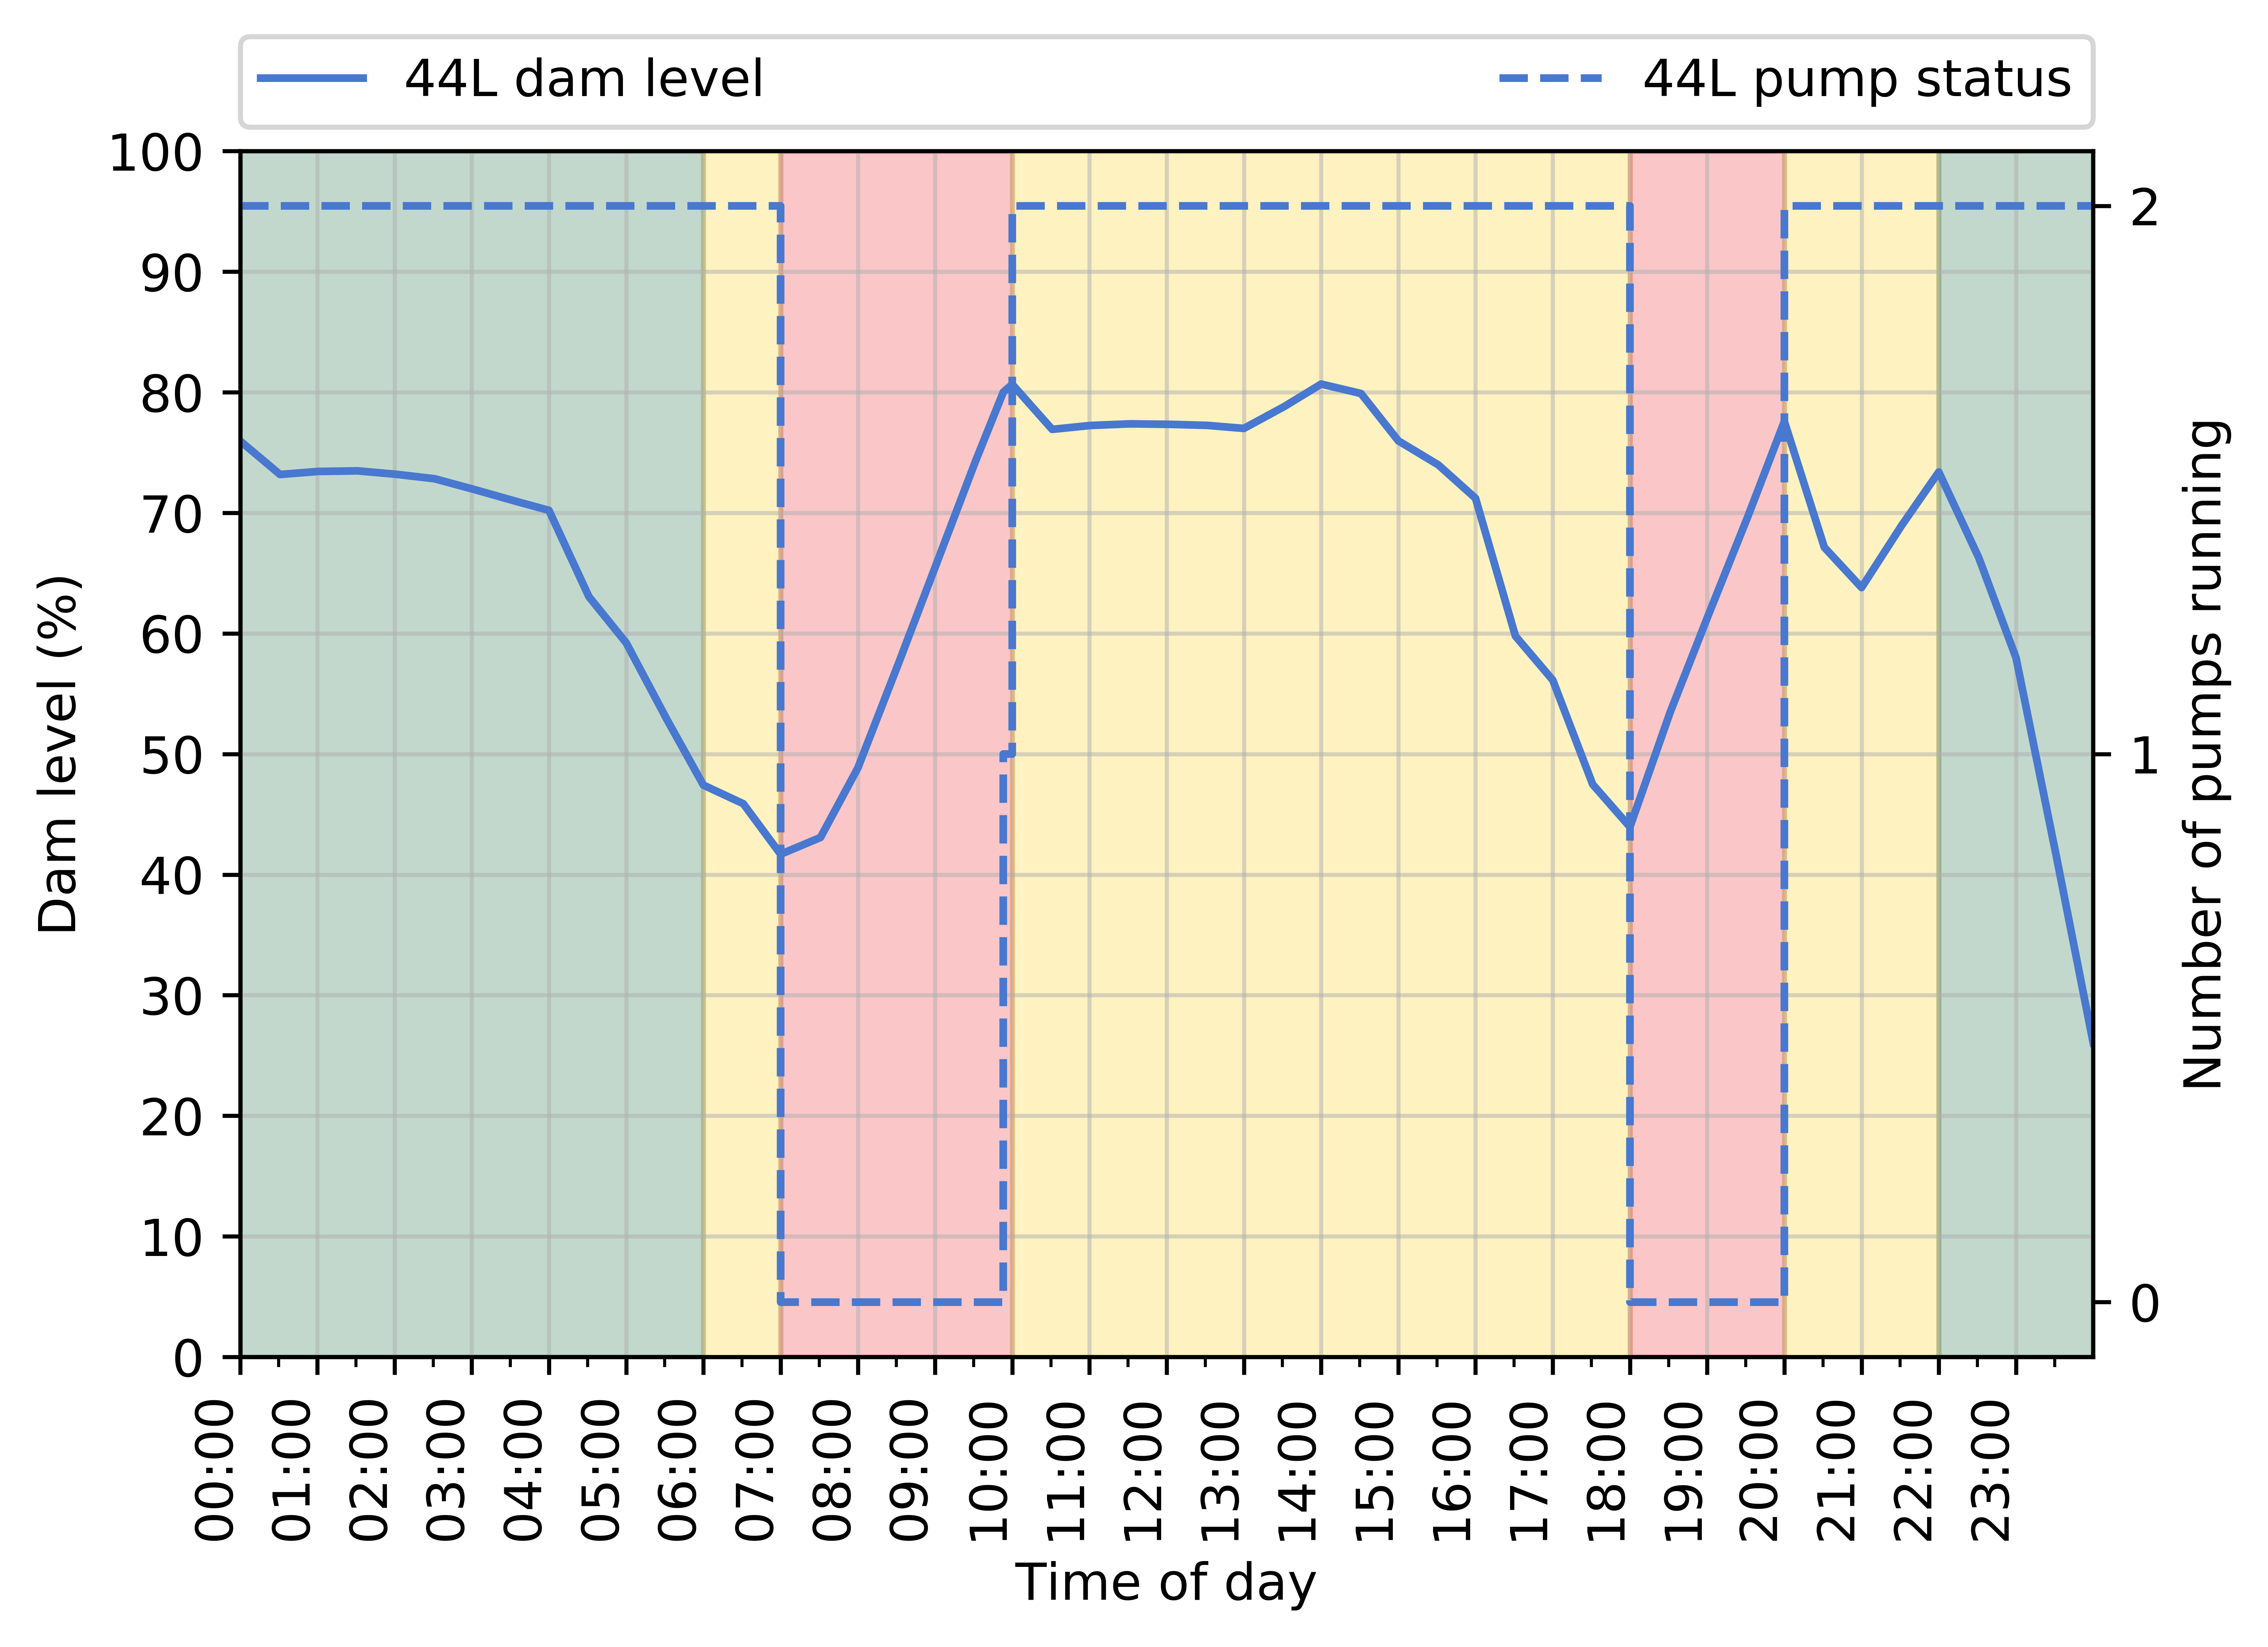

In [35]:
x = df['time_clean']

fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

lines1 = ax1.plot(x, df[[col for col in df.columns if 'level' in col.lower()]])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax2 = ax1.twinx()
lines2 = ax2.plot(x, df[[col for col in df.columns if 'Status' in col]], '--')

ax1.set_xlabel('Time of day')
ax1.set_ylabel('Dam level (%)')
ax1.set_ylim([0, 100])
ax2.set_ylabel('Number of pumps running')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_ticks(np.arange(0, 101, 10))
ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x), max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)
#ax2.grid(which='major', alpha=0.5)
#ax1.minorticks_on()

p = lines1 + lines2
plt.legend(p, ['44L dam level', '44L pump status'],
          bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)
#plt.legend(p,[p_.get_label() for subp in p for p_ in subp])

#plt.legend(lines1, ('a','b'), loc='best')
#plt.legend(lines2, ('c','d'), loc='best')

fig.tight_layout()
plt.show()

fig.savefig('output/k3_2_level_and_status.png', bbox_inches='tight'),

plt.close('all')

### Plot power

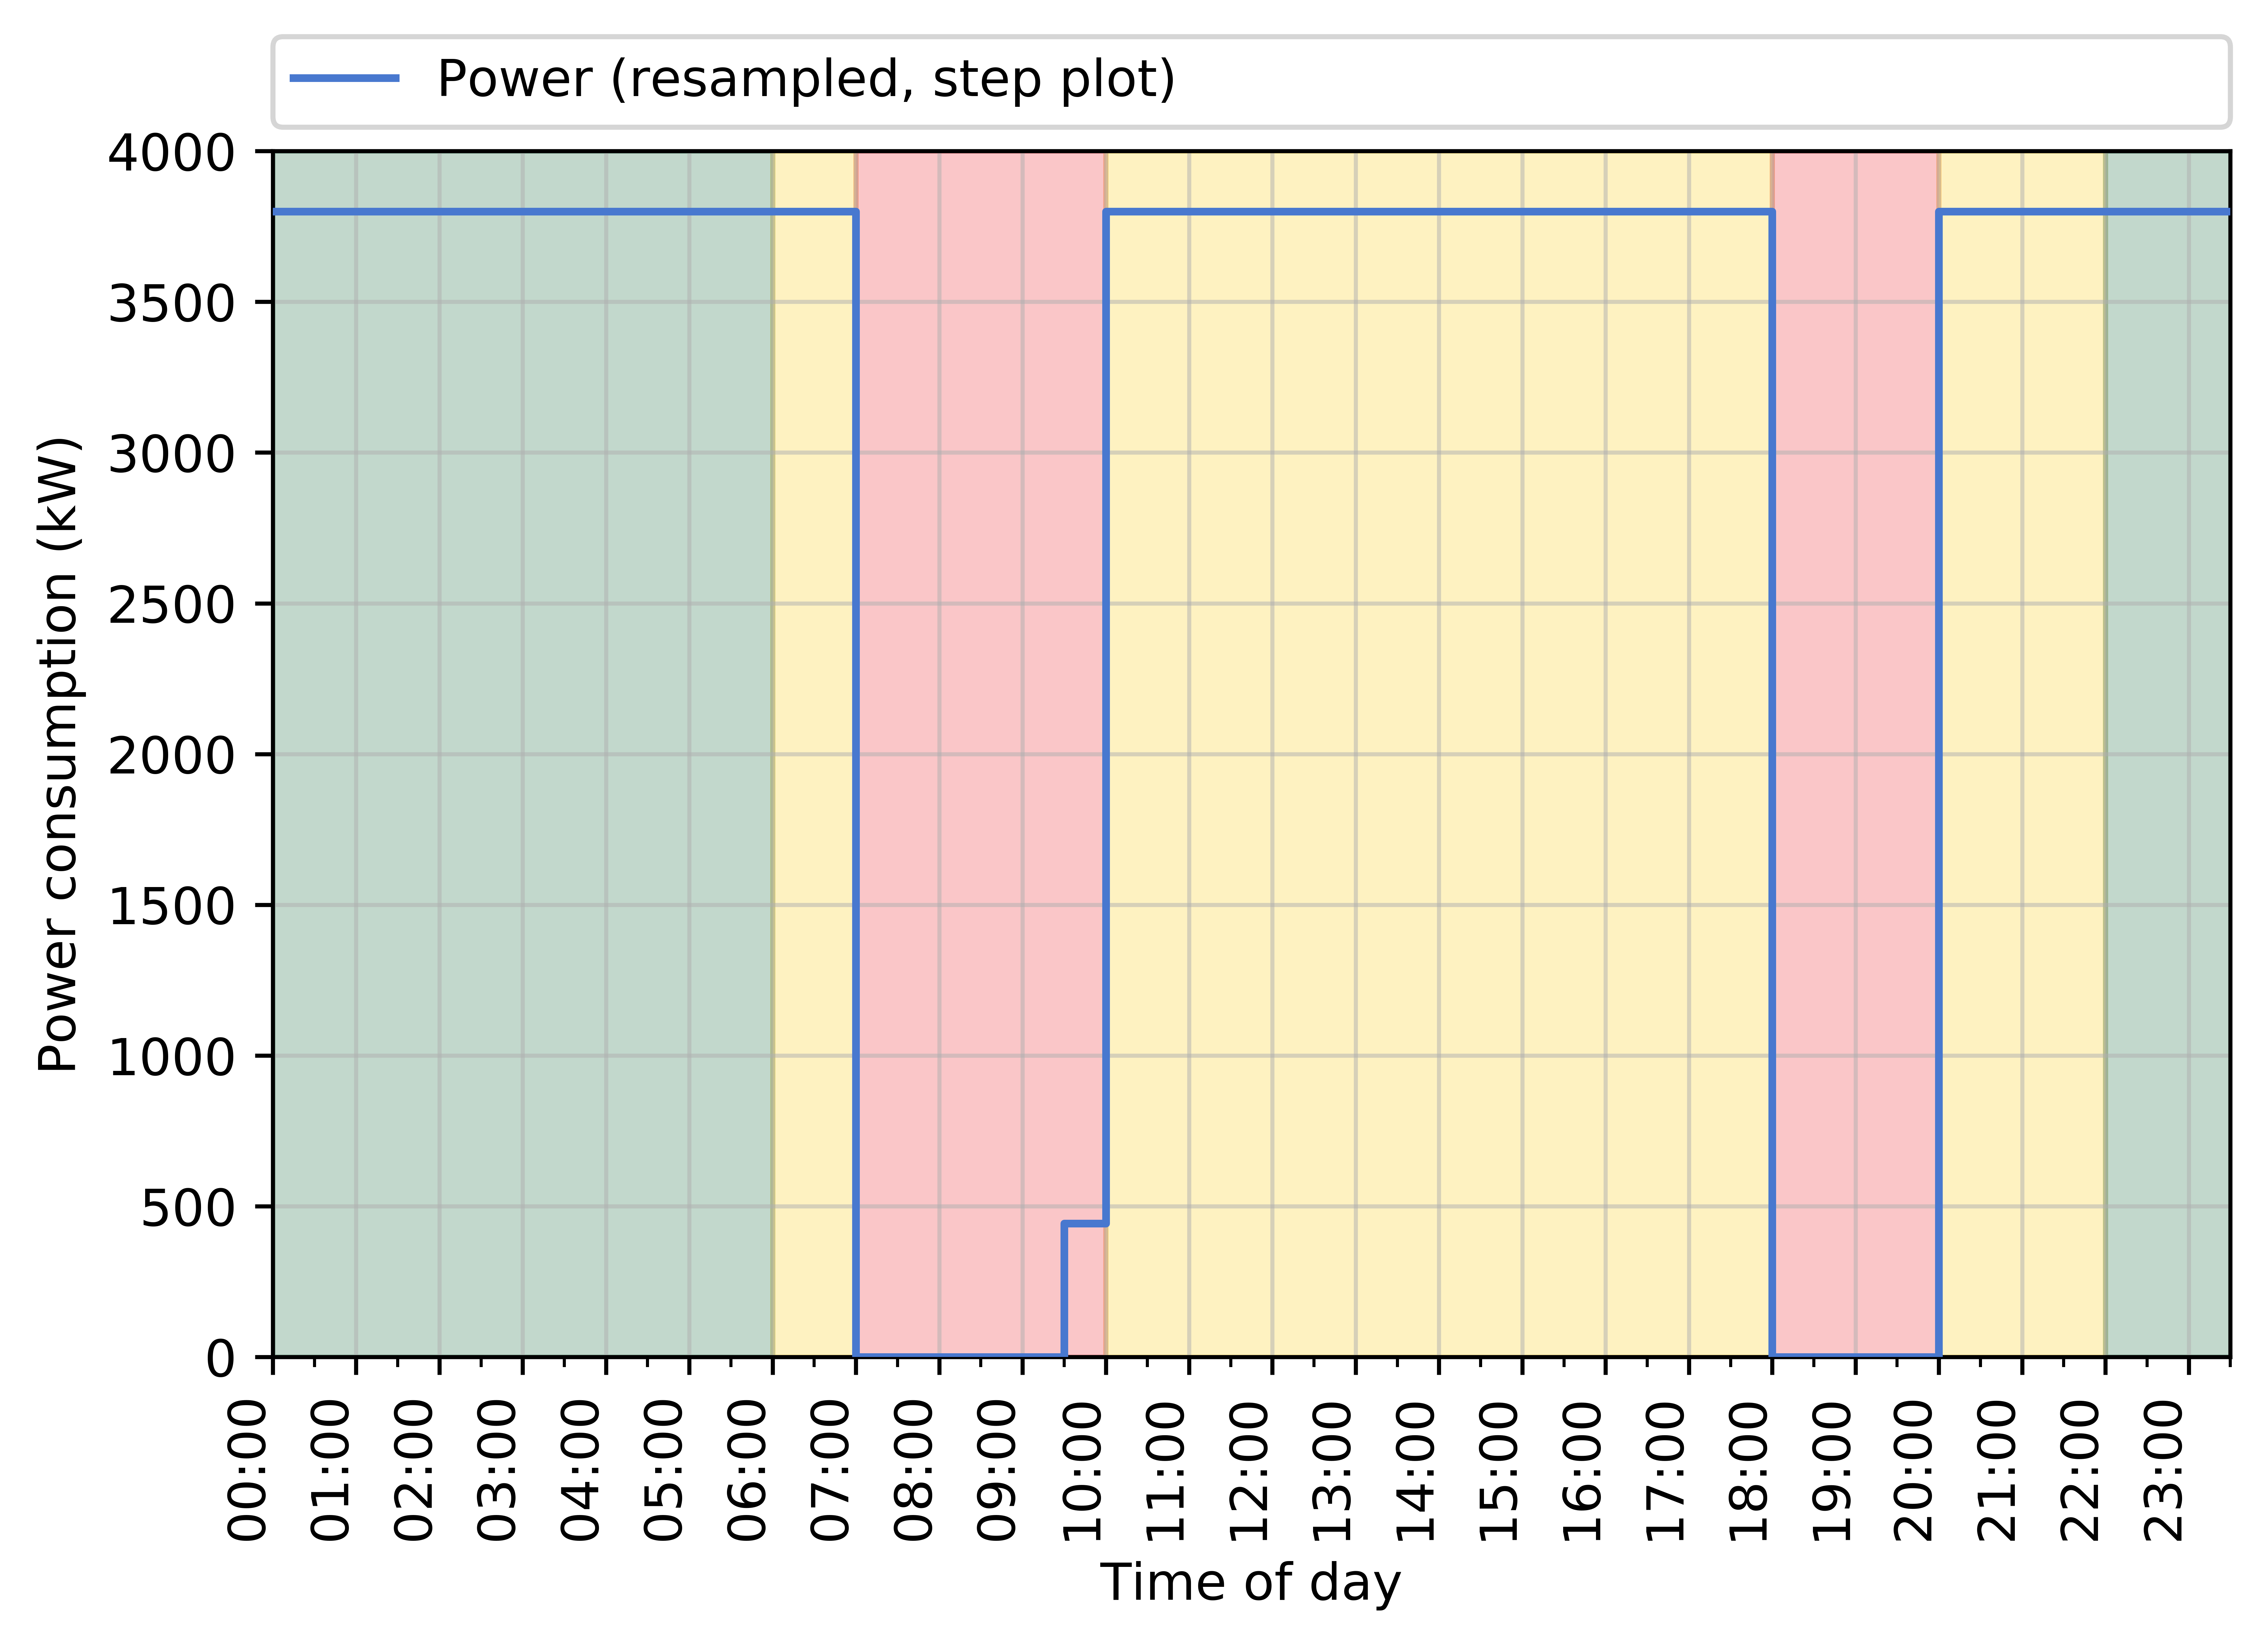

In [36]:
resampled = pd.DataFrame()
resampled['total_30_minute'] = df.set_index('time_clean')['Pump system total power'].resample('30T').mean()
resampled.to_csv('output/K3_resampled_power_2_factor.csv')

fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

x = resampled.index
y = resampled['total_30_minute']

ax1.plot(x,y, drawstyle='steps-post', label='Power (resampled, step plot)', zorder=3)
ax1.set_xlabel('Time of day')
ax1.set_ylabel('Power consumption (kW)')
ax1.set_ylim([0, 4000])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x),max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.5),

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)

fig.tight_layout()
plt.show()

fig.savefig('output/k3_2_power_resampled.png', bbox_inches='tight'),

plt.close('all')

## n-factor

In [37]:
df = pd.read_csv('..\..\simulations\K3\output\K3_simulation_data_export_n-factor.csv.gz')
df['time_clean'] = pd.to_datetime(df['seconds'], unit='s')
df.head()

seconds  44L Level  44L Status  Eskom ToU  Pump system total power  \
0        0  75.962773         2.0          3                   3800.0   
1        1  75.961277         2.0          3                   3800.0   
2        2  75.959780         2.0          3                   3800.0   
3        3  75.958283         2.0          3                   3800.0   
4        4  75.956786         2.0          3                   3800.0   

           time_clean  
0 1970-01-01 00:00:00  
1 1970-01-01 00:00:01  
2 1970-01-01 00:00:02  
3 1970-01-01 00:00:03  
4 1970-01-01 00:00:04

### Plot dam level and status

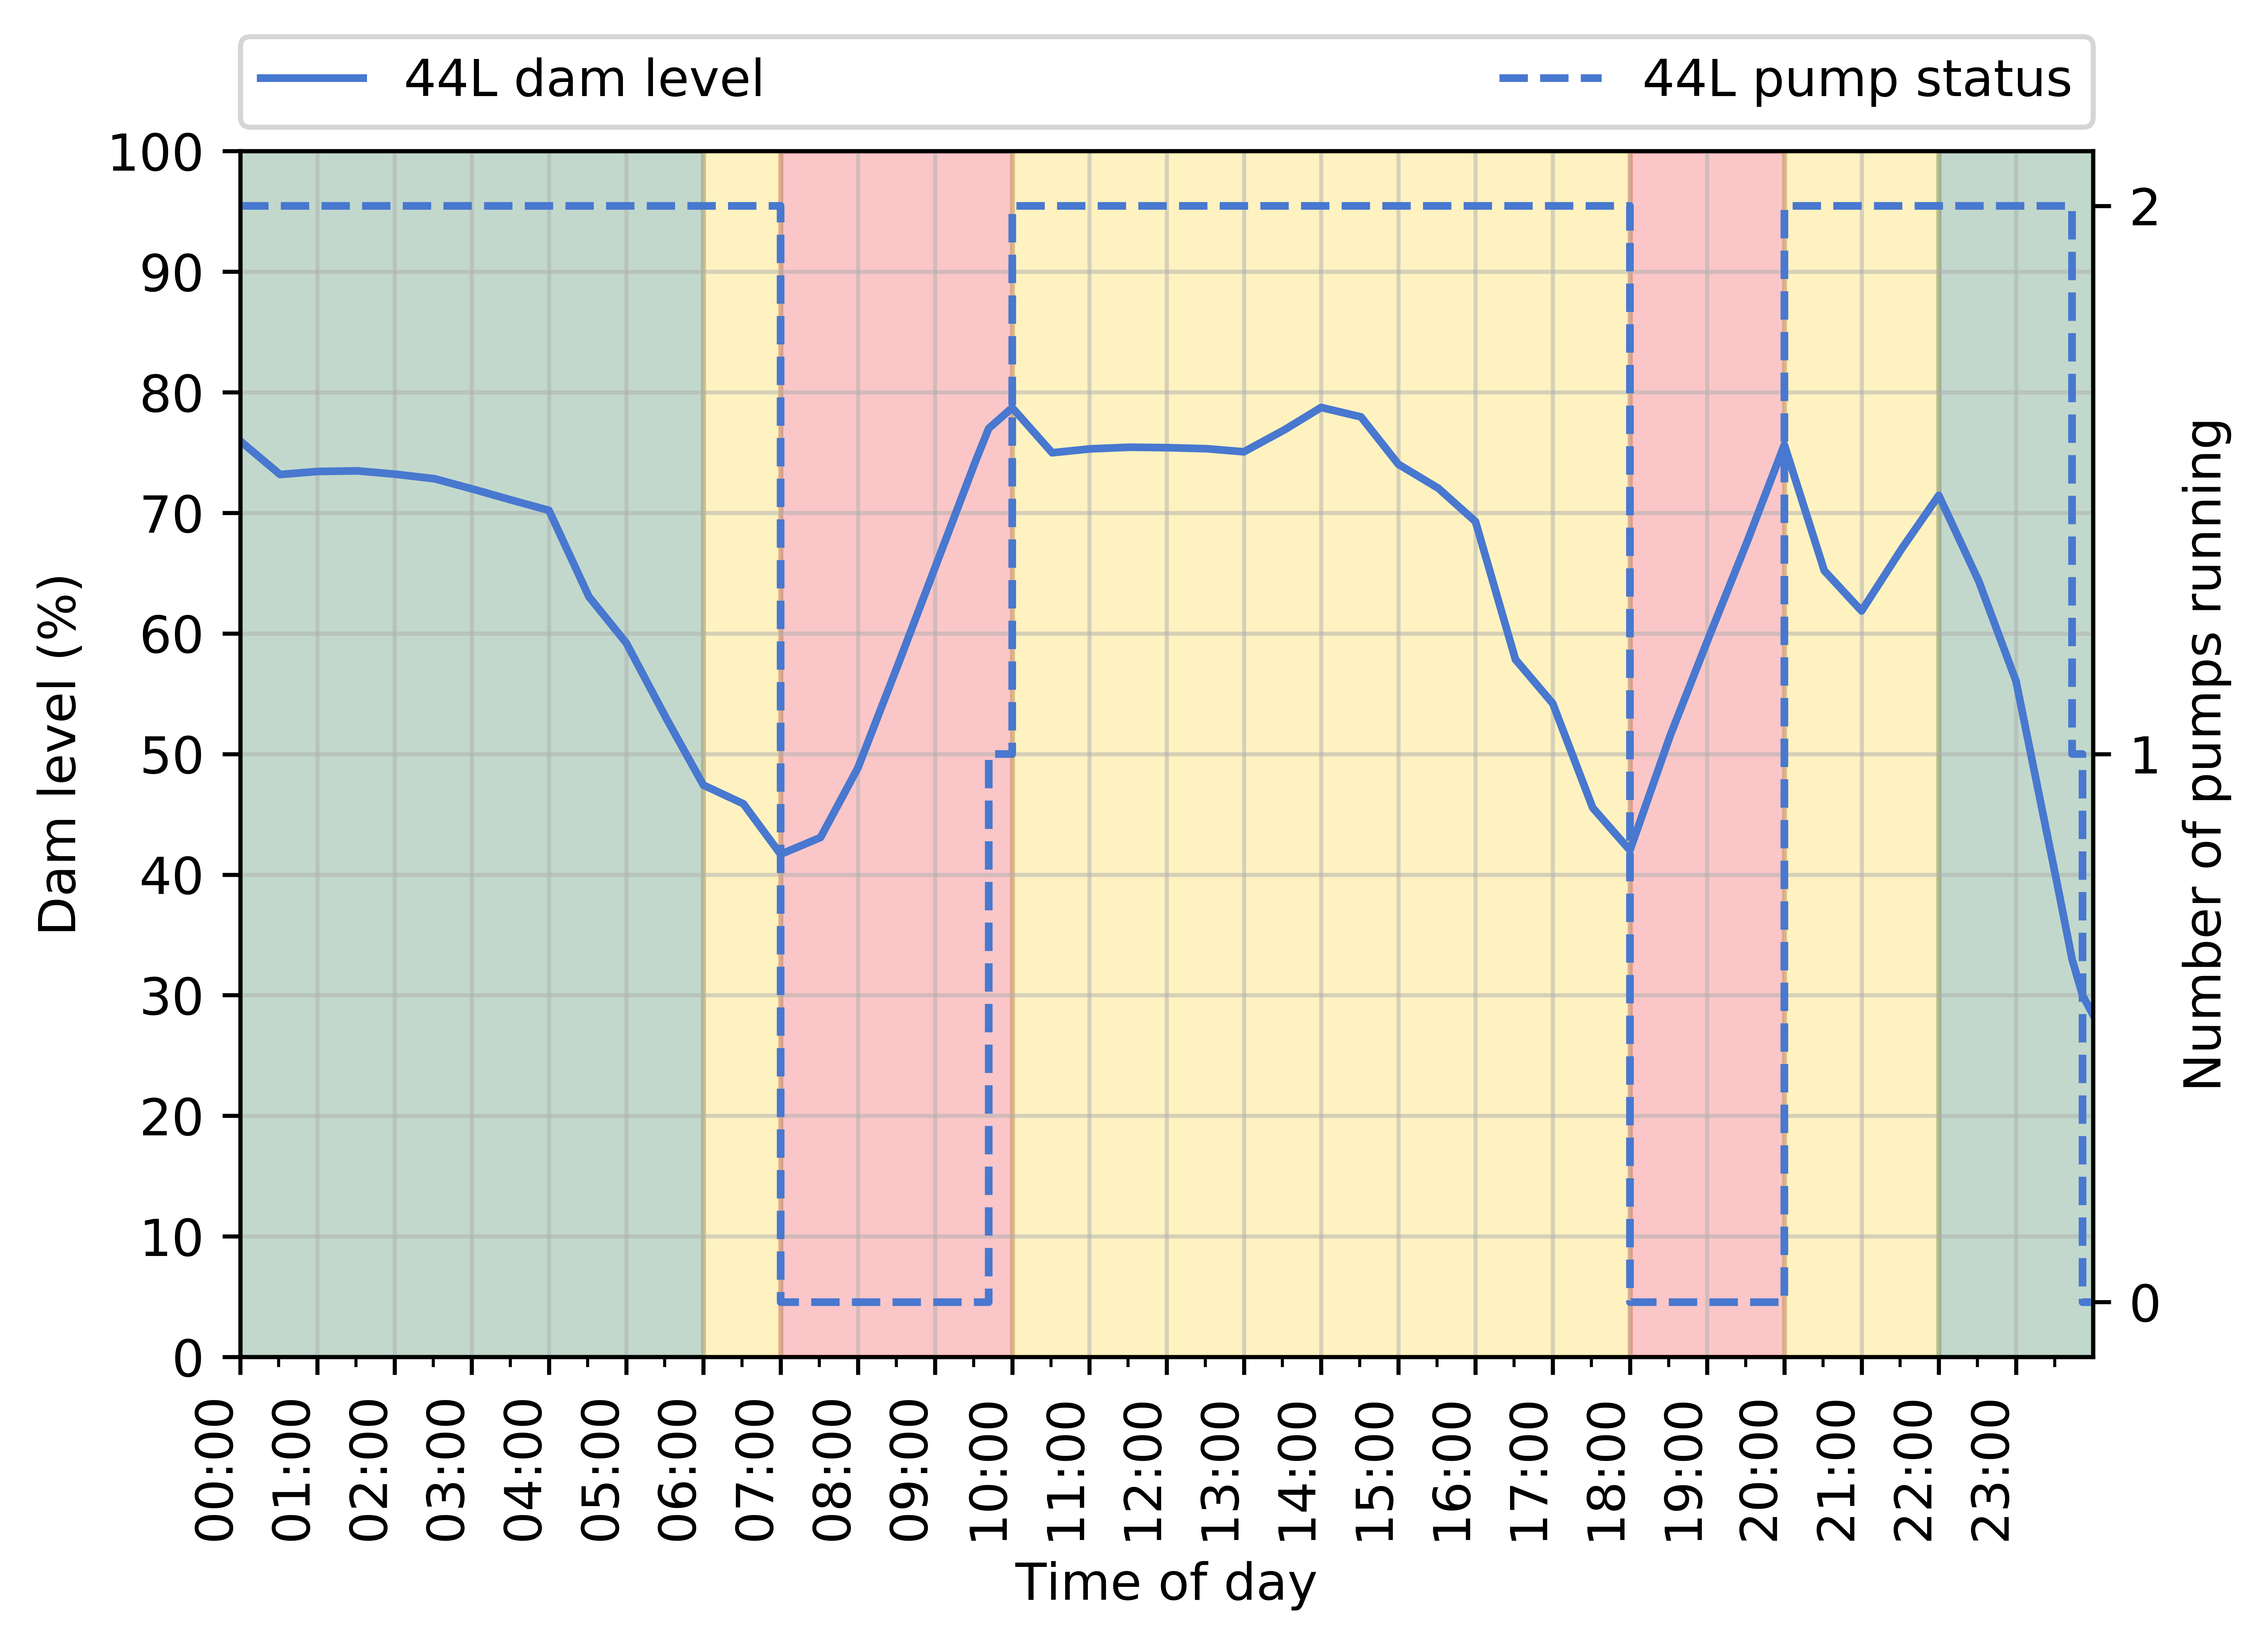

In [38]:
x = df['time_clean']

fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

lines1 = ax1.plot(x, df[[col for col in df.columns if 'level' in col.lower()]])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax2 = ax1.twinx()
lines2 = ax2.plot(x, df[[col for col in df.columns if 'Status' in col]], '--')

ax1.set_xlabel('Time of day')
ax1.set_ylabel('Dam level (%)')
ax1.set_ylim([0, 100])
ax2.set_ylabel('Number of pumps running')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_ticks(np.arange(0, 101, 10))
ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x), max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)
#ax2.grid(which='major', alpha=0.5)
#ax1.minorticks_on()

p = lines1 + lines2
plt.legend(p, ['44L dam level', '44L pump status'],
          bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)
#plt.legend(p,[p_.get_label() for subp in p for p_ in subp])

#plt.legend(lines1, ('a','b'), loc='best')
#plt.legend(lines2, ('c','d'), loc='best')

fig.tight_layout()
plt.show()

fig.savefig('output/k3_n_level_and_status.png', bbox_inches='tight'),

plt.close('all')

### Plot power

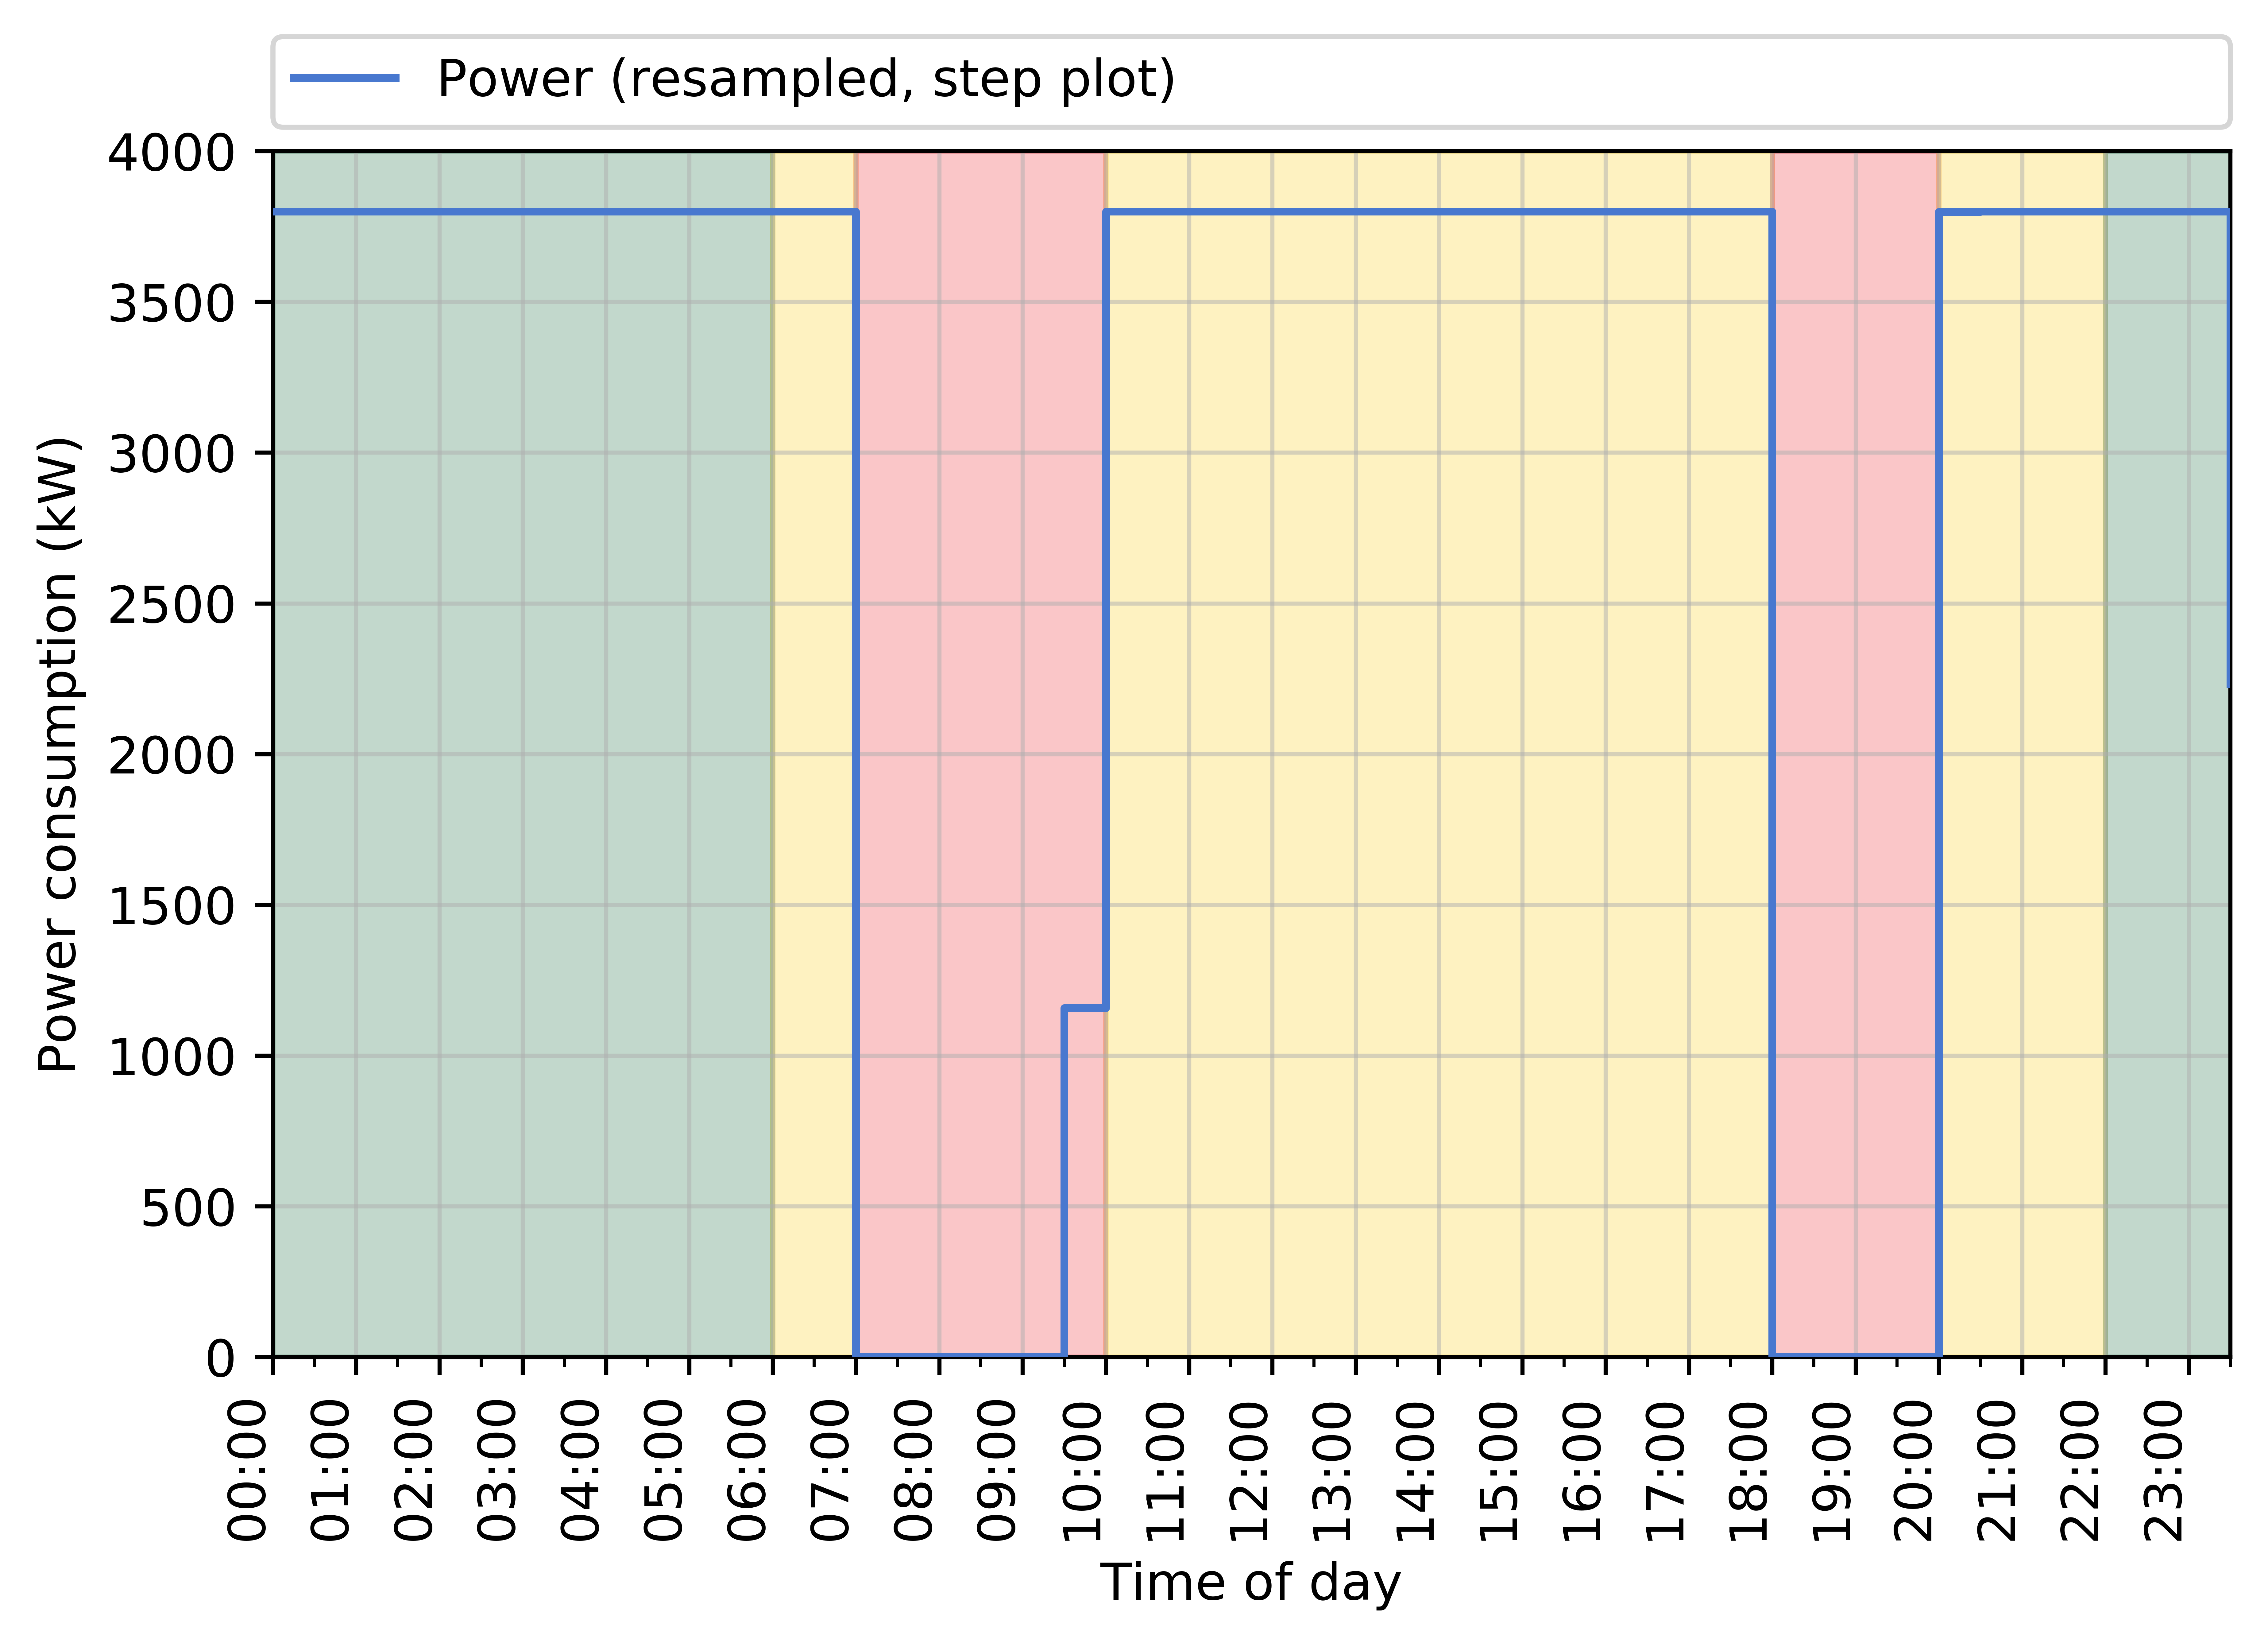

In [39]:
resampled = pd.DataFrame()
resampled['total_30_minute'] = df.set_index('time_clean')['Pump system total power'].resample('30T').mean()

resampled.to_csv('output/K3_resampled_power_n_factor.csv')

fig, ax1 = plt.subplots(figsize=figure_size, dpi=1200)
#fig.patch.set_facecolor('grey')

x = resampled.index
y = resampled['total_30_minute']

ax1.plot(x,y, drawstyle='steps-post', label='Power (resampled, step plot)', zorder=3)
ax1.set_xlabel('Time of day')
ax1.set_ylabel('Power consumption (kW)')
ax1.set_ylim([0, 4000])

ax1.axvspan('1970-01-01 00:00:00','1970-01-01 05:59:59', alpha=.25, color=colour_op, zorder=0)
ax1.axvspan('1970-01-01 06:00:00','1970-01-01 06:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 07:00:00','1970-01-01 09:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 10:00:00','1970-01-01 17:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 18:00:00','1970-01-01 19:59:59', alpha=.25, color=colour_p, zorder=0)
ax1.axvspan('1970-01-01 20:00:00','1970-01-01 21:59:59', alpha=.25, color=colour_s, zorder=0)
ax1.axvspan('1970-01-01 22:00:00','1970-01-01 23:59:59', alpha=.25, color=colour_op, zorder=0)

ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate(rotation=90)
ax1.set_xlim((min(x),max(x)))

ax1.grid(which='major', alpha=0.5)
#ax1.grid(which='minor', alpha=0.25)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0.)

fig.tight_layout()
plt.show()

fig.savefig('output/k3_n_power_resampled.png', bbox_inches='tight')

plt.close('all')